This notebook is a standalone simulation of PCR amplification and sequencing of UMI-tagged fragments followed by removal of PCR duplicates using the methods implemented in dedup_umi.py.

The notebook works from the ground up, starting with basic functions to simulate random selection of UMIs and amplification and then building in errors and deduplication before finishing off with an object to perform simulations across a range of input values and return plots of metrics.

This notebook can be run from start to finish without any user input. If you've already run the simulations, you can skip to the cell prior to plotting to read in the simulations data

In [1]:
import numpy as np
import collections
import pandas as pd 
import os
from time import gmtime, strftime
%load_ext rpy2.ipython

In [2]:
# wkdir
wd = "."
#wd = "figures.dir"

# directory for plots
%R plotdir <- "../figures.dir/"

array(['../figures.dir/'], 
      dtype='|S15')

First, a function to randomly select UMIs

In [3]:
def createUMIs(n, UMI_size):
    '''this function creates a list of random UMIs
    n = the length of the list
    UMI_size = the length of the UMI
    
    assumption is that UMIs are truly random, e.g equal probability of
    each base at each position. This is not actually the case(!)
    '''
    
    UMIs = []
    for umi in range(0, n):
        UMI = ""
        for base in range(0, UMI_size):
            UMI+=np.random.choice(["A","C", "G", "T"])
        
        UMIs.append(UMI)
        
    return UMIs

        
        


In [4]:
print createUMIs(2,5)

['TCACG', 'AGGTT']


Next, a function to amplify the pool of UMIs and a function to simulate a PCR amplification cycles

In [5]:
def amplify(UMI, efficiency=1):
    '''simulate amplification on a single UMI
    efficiency'''
    assert efficiency > 0 and efficiency <=1, "PCR efficiency must be between 0 and 1"
    
    if efficiency==1:
        return (UMI, UMI)
    else:
        if np.random.random()>(1-efficiency):
            return (UMI, UMI)
        else:
            return (UMI,)
    

In [6]:
def simulatePCRcycle(UMIs, efficiency=1):
    new_list = []
    for umi in UMIs:
        new_list.extend(amplify(umi, efficiency))
    return new_list

In [7]:
print amplify("AAAAA")
print amplify("AAAAA", 0.5)
print amplify("AAAAA", 0.5)
print amplify("AAAAA", 0.5)
print amplify("AAAAA", 0.5)

('AAAAA', 'AAAAA')
('AAAAA', 'AAAAA')
('AAAAA', 'AAAAA')
('AAAAA', 'AAAAA')
('AAAAA',)


In [8]:
umis = simulatePCRcycle(UMIs = createUMIs(n=5,UMI_size=6), efficiency=0.5)
print umis
print collections.Counter(umis).most_common()

['TCCATG', 'TCCATG', 'CTCGCT', 'CTCGCT', 'TTCATT', 'ACCGGC', 'TAGGGA']
[('CTCGCT', 2), ('TCCATG', 2), ('TAGGGA', 1), ('ACCGGC', 1), ('TTCATT', 1)]


Now, we need a function to simulate multiple PCR cycles. We only need to return the final counts for each UMI

In [9]:
def PCRcycles(UMIs, efficiency, PCR_cycles):

    if PCR_cycles == 0:
        return collections.Counter(UMIs)
    
    for cycle in range(0, PCR_cycles):
        post_cycle=simulatePCRcycle(UMIs, efficiency = efficiency)
        UMIs=post_cycle
        
        return collections.Counter(post_cycle)

In [10]:
PCR_cycles = 5
efficiency= 0.8 # PCR efficiency
# initial UMIs, e.g the true number of molecules at a given loci/gene depending on method
UMIs = createUMIs(5,5)

final_UMIs = PCRcycles(UMIs, efficiency, PCR_cycles)
print final_UMIs

Counter({'TTTGG': 2, 'TTTTC': 2, 'GCCCT': 1, 'TCACC': 1, 'TGGAG': 1})


Now, let's add an error rate for sequencing errors: Go through each UMI in the counter and random add errors

In [11]:
def addSequencingErrors(UMI_counter, seq_error_rate=0.01):
    '''takes a UMI counter object and adds errors at random to simulate sequencing errors'''
    errors_dict = {"A":["C", "G", "T"],
                   "C":["A", "G", "T"],
                   "G":["C", "A", "T"],
                   "T":["C", "G", "A"]}
    new_list = []
    for umi in UMI_counter.elements():
        new_umi = ""
        for base in umi:
            if np.random.random() > seq_error_rate:
                new_umi += base
            else:
                new_umi += np.random.choice(errors_dict[base])
        
        new_list.append(new_umi)
    
    return collections.Counter(new_list)
            
    

In [12]:
number_of_UMIs = 10
length_of_UMIs = 5
PCR_cycles = 5
efficiency= 0.8 # PCR efficiency

# initial UMIs, e.g the true number of molecules at a given loci/gene depending on method
UMIs = createUMIs(number_of_UMIs, length_of_UMIs)
print "number of UMIs before sequencing:", len(UMIs)

final_UMIs = PCRcycles(UMIs, efficiency, PCR_cycles)
UMIs_after_seq = addSequencingErrors(final_UMIs)
print "number of UMIs after sequencing:", len(UMIs_after_seq)


number of UMIs before sequencing: 10
number of UMIs after sequencing: 10


So we're ending up with more UMIs after simulating sequencing that we started with. This is what we expect.

Now we need to add errors during the PCR amplification (we need a estimate for error rates for the recombinant DNA polymerase used)

http://www.hindawi.com/journals/mbi/2014/287430/
AccuPrime-Taq: 1.0 × 10−5 = 0.00001 error rate

In [13]:
def amplifyWithErrors(UMI, efficiency=1, error_rate=0.00001):
    '''simulate amplification on a single UMI
    efficiency'''
    
    errors_dict = {"A":["C", "G", "T"],
               "C":["A", "G", "T"],
               "G":["C", "A", "T"],
               "T":["C", "G", "A"]}
    
    assert efficiency > 0 and efficiency <=1, "PCR efficiency must be between 0 and 1"
    
    if efficiency == 1:
        if error_rate == 0:
            return (UMI, UMI)
        else:
            new_umi = ""
            for base in UMI:
                if np.random.random()<=error_rate:
                    new_umi += np.random.choice(errors_dict[base])
                else:
                    new_umi += base
            return (UMI, new_umi)
        
    else:
        if np.random.random()>(1-efficiency):
            if error_rate == 0:
                return (UMI, UMI)
            else:
                new_umi = ""
                for base in UMI:
                    if np.random.random()<=error_rate:
                        new_umi += np.random.choice(errors_dict[base])
                    else:
                        new_umi += base
            return (UMI, new_umi)
        
        else:
            return (UMI,)
        
def simulatePCRcycleWithErrors(UMIs, efficiency=1, error_rate=0.00001):
    new_list = []
    for umi in UMIs:
        new_list.extend(amplifyWithErrors(umi, efficiency))
    return new_list


def PCRcyclesWithErrors(UMIs, efficiency, PCR_cycles, error_rate=0.00001):

    if PCR_cycles == 0:
        return collections.Counter(UMIs)
    
    else:
        for cycle in range(0, PCR_cycles):
            post_cycle=simulatePCRcycleWithErrors(UMIs, efficiency, error_rate)
            UMIs=post_cycle
        
        return collections.Counter(post_cycle)
    


In [14]:
number_of_UMIs = 5
length_of_UMIs = 5
PCR_cycles = 10
error_rate=0.0001 # error_rate=0.00001 Recombinant Taq DNA pol error rate
seq_error_rate=0.001 # Phred = 30
efficiency= 0.9 # PCR efficiency - guestimate from - http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1298932/
# initial UMIs, e.g the true number of molecules at a given loci/gene depending on method

UMIs = createUMIs(number_of_UMIs, length_of_UMIs)

final_UMIs = PCRcyclesWithErrors(UMIs, efficiency, PCR_cycles, error_rate)
UMIs_after_seq = addSequencingErrors(final_UMIs, seq_error_rate)

print "number of UMIs before sequencing:", len(UMIs)
print "number of UMIs after PCR:", len(final_UMIs)
print "number of UMIs after sequencing:", len(UMIs_after_seq)

number of UMIs before sequencing: 5
number of UMIs after PCR: 5
number of UMIs after sequencing: 16


So, in this simulation, all of the increase in UMI number comes from the sequencing. (This is a random process so you may get a slightly different result). Again, this is what we expect given the much higher error rate for the sequencing. However, if the PCR cycles were increased the errors from DNA pol would start appearing (see next cell)

In [15]:
number_of_UMIs = 5
length_of_UMIs = 5
PCR_cycles = 15
error_rate=0.0001 # error_rate=0.00001 Recombinant Taq DNA pol error rate
seq_error_rate=0.001 # Phred = 30
efficiency= 0.9 # PCR efficiency - guestimate from - http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1298932/
# initial UMIs, e.g the true number of molecules at a given loci/gene depending on method

UMIs = createUMIs(number_of_UMIs, length_of_UMIs)

final_UMIs = PCRcyclesWithErrors(UMIs, efficiency, PCR_cycles, error_rate)
UMIs_after_seq = addSequencingErrors(final_UMIs, seq_error_rate)

print "number of UMIs before sequencing:", len(UMIs)
print "number of UMIs after PCR:", len(final_UMIs)
print "number of UMIs after sequencing:", len(UMIs_after_seq)

number of UMIs before sequencing: 5
number of UMIs after PCR: 9
number of UMIs after sequencing: 78


Let's make a functional equivalents of the various dedup methods to handle the Counter object.

In the tool itself we want to return the best read(s) at each location using the deduplication method. Here we can simply return the count of best read(s). For the network based methods, it would also be good to keep track of:
 - the number networks without any true UMIs
 - the number UMIs in these networks
 - the number networks with >=2 true UMIs
 
"none" method
    - return the total counts 

Unique method
    - return the length of the Counter

Percentile method
    - return all UMIs where the counts are greater than median/100

Cluster method
    - need to derive adjacency matrix from the Counts (Hamming distance =1)
    - return:
        - the count of connected components
        - # networks without any true UMIs
        - # UMIs in these networks
        - # networks with >=2 true UMIs
    
Adjacency method  
    - as above but for each connected component return the parent node (highest counts) and remove all connected nodes
    - repeat until all edges are removed in all connected components

Directional method
    - as above for Cluster method but derive a directional adjacency matrix (A >2B - 1)
                            

In [16]:
def countNetworksWithoutTrueUMI(clusters, true_UMIs):
    ''' count the number of networks without any true UMIs'''
    
    network_no_true = 0
    network_no_true_UMIs = 0
    for c in clusters:
        includes_true = False
        for umi in true_UMIs:
            if umi in c:
                includes_true = True
                break
        if not includes_true:
            network_no_true += 1
            network_no_true_UMIs += len(c)
            
    return network_no_true, network_no_true_UMIs

def dedup_none(Counter):
    return sum(Counter.viewvalues())

def dedup_unique(Counter):
    return len(Counter.keys())

def dedup_percentile(Counter):
    threshold = np.mean(Counter.values())/100
    return len([count for count in Counter.values() if count > threshold])


def edit_dist(first, second):
    ''' returns the edit distance/hamming distances between
    its two arguements '''

    dist = sum([not a == b for a, b in zip(first, second)])
    return dist

def breadth_first_search(node, adj_list):
    searched = set()
    found = set()
    queue = set()
    queue.update((node,))
    found.update((node,))
    
    while len(queue)>0:
        node=(list(queue))[0]
        found.update(adj_list[node])
        queue.update(adj_list[node])
        searched.update((node,))
        queue.difference_update(searched)
            
    return found

def dedup_cluster(Counter, true_UMIs):
    
    def get_adj_list_cluster(umis):
        return {umi: [umi2 for umi2 in umis if edit_dist(umi, umi2) == 1] for umi in umis}

    def get_connected_components_cluster(graph, Counter):

        found = list()
        components = list()

        for node in sorted(graph, key=lambda x: Counter[x], reverse=True):
            if node not in found:
                component = breadth_first_search(node, graph)
                found.extend(component)
                components.append(component)

        return components
   
    adj_list = get_adj_list_cluster(Counter.keys())
   
    clusters = get_connected_components_cluster(adj_list, Counter)
    network_no_true, network_no_true_UMIs = countNetworksWithoutTrueUMI(clusters, true_UMIs)
    
    return len(clusters), network_no_true, network_no_true_UMIs

def dedup_adj(Counter, true_UMIs, threshold=1):
    
    def get_adj_list_adjacency(umis, threshold=1):
        return {umi: [umi2 for umi2 in umis if edit_dist(umi, umi2) <= threshold and umi != umi2]
                for umi in umis}

    def get_connected_components_adjacency(graph, Counter):

        found = list()
        components = list()

        for node in sorted(graph, key=lambda x: Counter[x], reverse=True):
            if node not in found:
                component = breadth_first_search(node, graph)
                found.extend(component)
                components.append(component)

        return components

    def remove_umis(adj_list, cluster, nodes):
        '''removes the specified nodes from the cluster and returns
        the remaining nodes '''

        # list incomprehension: for x in nodes: for node in adj_list[x]: yield node
        nodes_to_remove = set([node
                               for x in nodes
                               for node in adj_list[x]] + nodes)

        return cluster - nodes_to_remove


    def get_best_adjacency(cluster, adj_list, counts):

        if len(cluster) == 1:
            return list(cluster)

        sorted_nodes = sorted(cluster, key=lambda x: counts[x],
                              reverse=True)

        for i in range(len(sorted_nodes) - 1):
            if len(remove_umis(adj_list, cluster, sorted_nodes[:i+1])) == 0:
                return sorted_nodes[:i+1]

            
    def reduce_clusters_adjacency(adj_list, clusters, counts):

    # TS - the "adjacency" variant of this function requires an adjacency
    # list to identify the best umi, whereas the other variants don't
    # As temporary solution, pass adj_list to all variants

        n=0

        for cluster in clusters:
            parent_umis = get_best_adjacency(cluster, adj_list, counts)
            n += len(parent_umis)

        return n 


    
    adj_list = get_adj_list_adjacency(Counter.keys(), threshold)
   
    clusters = get_connected_components_adjacency(adj_list, Counter)
    network_no_true, network_no_true_UMIs = countNetworksWithoutTrueUMI(clusters, true_UMIs)
    count = reduce_clusters_adjacency(adj_list, clusters, Counter)
    
    return count, network_no_true, network_no_true_UMIs




def dedup_dir(Counter, true_UMIs, threshold=1):

    def get_adj_list_directional(umis, counts, threshold=1):

        return {umi: [umi2 for umi2 in umis if edit_dist(umi, umi2) <= threshold and
                      umi != umi2 and 
                      counts[umi] >= (counts[umi2]*2)-1] for umi in umis}  
    
    def get_connected_components_adjacency(graph, Counter):

        found = list()
        components = list()

        for node in sorted(graph, key=lambda x: Counter[x], reverse=True):
            if node not in found:
                component = breadth_first_search(node, graph)
                found.extend(component)
                components.append(component)

        return components

    def remove_umis(adj_list, cluster, nodes):
        '''removes the specified nodes from the cluster and returns
        the remaining nodes '''

        # list incomprehension: for x in nodes: for node in adj_list[x]: yield node
        nodes_to_remove = set([node
                               for x in nodes
                               for node in adj_list[x]] + nodes)

        return cluster - nodes_to_remove
       
            
    def reduce_clusters_directional(adj_list, clusters, counts):

        n = 0

        for cluster in clusters:
            n+=1

        return n
    
    
    adj_list = get_adj_list_directional(Counter.keys(), Counter, threshold)
   
    clusters = get_connected_components_adjacency(adj_list, Counter)
    network_no_true, network_no_true_UMIs = countNetworksWithoutTrueUMI(clusters, true_UMIs)
    
    count = reduce_clusters_directional(adj_list, clusters, Counter)
    
    return count, network_no_true, network_no_true_UMIs
    
    
    

One last step - We need to model the effect of bias in amplifying each UMI. We can do this naively by sampling from a uniform range for the efficiency of amplification (fixed for each UMI)

In [17]:
gt = UMIs
print gt
dedup_adj(UMIs_after_seq, gt)


['TTGCG', 'TCTGC', 'CGGAT', 'GGCCT', 'TGGGG']


(5, 0, 0)

In [18]:
def simulatePCRcycleWithErrorsAndBias(UMIs, efficiency_min, efficiency_max,
                                      efficiency_dict, error_rate=0.00001):
    new_list = []
    for umi in UMIs:
        if not efficiency_dict[umi]:
            efficiency_dict[umi] = np.random.uniform(efficiency_min, efficiency_max)
        new_list.extend(amplifyWithErrors(umi, efficiency_dict[umi], error_rate))
    return new_list


def PCRcyclesWithErrorsAndBias(UMIs, efficiency_min, efficiency_max,
                               efficiency_dict,PCR_cycles, error_rate=0.00001):

    if PCR_cycles==0:
        return collections.Counter(UMIs)
    
    else:
        for cycle in range(0, PCR_cycles):
            post_cycle=simulatePCRcycleWithErrorsAndBias(UMIs, efficiency_min, efficiency_max,
                                                     efficiency_dict, error_rate)
            UMIs=post_cycle
        
        return collections.Counter(post_cycle)

def createUMIsWithBias(n, UMI_size, efficiency_min, efficiency_max):
    '''this function creates a list of random UMIs
    n = the length of the list
    UMI_size = the length of the UMI
    
    assumption is that UMIs are truly random, e.g equal probability of
    each base at each position. This is not actually the case(!)
    
    Also now returns a dictionary of simulated efficiencies
    '''
    assert efficiency_min > 0 and efficiency_max <=1, "PCR efficiencies must be between 0 and 1"
    
    UMIs = []
    efficiency_dict = collections.defaultdict(float)
    for umi in range(0, n):
        UMI = ""
        for base in range(0, UMI_size):
            UMI+=np.random.choice(["A","C", "G", "T"])
        
        UMIs.append(UMI)
        efficiency_dict[UMI] = np.random.uniform(efficiency_min, efficiency_max)
    
        
    return UMIs, efficiency_dict

In [19]:
eff_min = 0.9
eff_max = 1

UMIs, efficiency_dict = createUMIsWithBias(number_of_UMIs, length_of_UMIs, eff_min, eff_max)

final_UMIs = PCRcyclesWithErrorsAndBias(UMIs, eff_min, eff_max, efficiency_dict, PCR_cycles, error_rate)
UMIs_after_seq = addSequencingErrors(final_UMIs, seq_error_rate)    


Now, we'll quantify the accuracy of quantification. The best measure would be the coefficient of variation (sd/mean). For this, we would need to start with the same number of molecules (UMIs) and do n (10) iterations of the error generation and then quantify post "dedup"

In [20]:
iterations = 50
number_of_UMIs = 20
length_of_UMIs = 5
PCR_cycles = 10
error_rate=0.00001 # error_rate=0.00001 Recombinant Taq DNA pol error rate
seq_error_rate=0.001 # seq_error_rate=0.0005
efficiency_min= 0.6
efficiency_max= 1

no_dedup_counts = []
unique_dedup_counts = []
perc_dedup_counts = []
cluster_dedup_counts = []
adj_dedup_counts = []
adj_dedup2_counts = []
dir_dedup_counts = []
dir_dedup2_counts = []

for x in range(0, iterations):
   
    UMIs, efficiency_dict = createUMIsWithBias(number_of_UMIs, length_of_UMIs,
                                               efficiency_min, efficiency_max)

    final_UMIs = PCRcyclesWithErrorsAndBias(UMIs, efficiency_min, efficiency_max,
                                            efficiency_dict, PCR_cycles, error_rate)
    
    UMIs_after_seq = addSequencingErrors(final_UMIs, seq_error_rate)    
   
    no_dedup_counts.append(dedup_none(UMIs_after_seq))
    unique_dedup_counts.append(dedup_unique(UMIs_after_seq))
    perc_dedup_counts.append(dedup_percentile(UMIs_after_seq))
    cluster_dedup_counts.append(dedup_cluster(UMIs_after_seq, UMIs)[0])
    adj_dedup_counts.append(dedup_adj(UMIs_after_seq, UMIs,1)[0])
    adj_dedup2_counts.append(dedup_adj(UMIs_after_seq, UMIs,2)[0])
    dir_dedup_counts.append(dedup_dir(UMIs_after_seq, UMIs, 1)[0])
    dir_dedup2_counts.append(dedup_dir(UMIs_after_seq, UMIs, 2)[0])
    
no_dedup_CV = np.std(no_dedup_counts)/np.mean(no_dedup_counts)
unique_dedup_CV = np.std(unique_dedup_counts)/np.mean(unique_dedup_counts)
perc_dedup_CV = np.std(perc_dedup_counts)/np.mean(perc_dedup_counts)
cluster_dedup_CV = np.std(cluster_dedup_counts)/np.mean(cluster_dedup_counts)
adj_dedup_CV = np.std(adj_dedup_counts)/np.mean(adj_dedup_counts)
adj_dedup2_CV = np.std(adj_dedup2_counts)/np.mean(adj_dedup2_counts)
dir_dedup_CV = np.std(dir_dedup_counts)/np.mean(dir_dedup_counts)
dir_dedup2_CV = np.std(dir_dedup2_counts)/np.mean(dir_dedup2_counts)

    
    
print (no_dedup_CV, unique_dedup_CV, perc_dedup_CV, cluster_dedup_CV,
       adj_dedup_CV, adj_dedup2_CV, dir_dedup_CV, dir_dedup2_CV)

(0.16699471642388, 0.11544425672272532, 0.096819545057829207, 0.33042714592695327, 0.084903365280148538, 0.11705734554195529, 0.061769490822989548, 0.15260719256489408)


Let's turn this into a function, up the iterations and repeat for different numbers of molecules

In [21]:
def CountsPerMethod(iterations, number_of_UMIs, length_of_UMIs, PCR_cycles,
                error_rate, seq_error_rate, efficiency_min, efficiency_max):
    
    no_dedup_results = []
    unique_dedup_results = []
    perc_dedup_results = []
    cluster_dedup_results = []
    adj_dedup_results = []
    adj_dedup2_results = []
    dir_dedup_results = []
    dir_dedup2_results = []
    
    for x in range(0, iterations):

        UMIs, efficiency_dict = createUMIsWithBias(number_of_UMIs, length_of_UMIs,
                                                   efficiency_min, efficiency_max)

        final_UMIs = PCRcyclesWithErrorsAndBias(UMIs, efficiency_min, efficiency_max,
                                                efficiency_dict, PCR_cycles, error_rate)

        UMIs_after_seq = addSequencingErrors(final_UMIs, seq_error_rate)    

        no_dedup_results.append(dedup_none(UMIs_after_seq))
        unique_dedup_results.append(dedup_unique(UMIs_after_seq))
        perc_dedup_results.append(dedup_percentile(UMIs_after_seq))
        cluster_dedup_results.append(dedup_cluster(UMIs_after_seq, UMIs)[0])
        adj_dedup_results.append(dedup_adj(UMIs_after_seq, UMIs, 1)[0])
        adj_dedup2_results.append(dedup_adj(UMIs_after_seq, UMIs, 2)[0])
        dir_dedup_results.append(dedup_dir(UMIs_after_seq, UMIs, 1)[0])
        dir_dedup2_results.append(dedup_dir(UMIs_after_seq, UMIs, 2)[0])

        
    return (no_dedup_results, unique_dedup_results, perc_dedup_results,
            cluster_dedup_results, adj_dedup_results, adj_dedup2_results,
            dir_dedup_results, dir_dedup2_results)

In [22]:
iterations = 10 # iterations per simulation to estimate coefficient of variation
length_of_UMIs = 5 
PCR_cycles = 10
error_rate=0.00001 # error_rate=0.00001 Recombinant Taq DNA pol error rate
seq_error_rate=0.001 # seq_error_rate=0.0005

# these define the level of bias in the PCR amplification
efficiency_min= 0.5 # minimum efficiency of PCR amplifiaction
efficiency_max= 0.99

min_number_UMIs=1
max_number_UMIs=50
step = 10

df = pd.DataFrame(columns=('number_of_molecules', 'dedup', 'count', 'CV'))
for number_of_UMIs in range(min_number_UMIs, max_number_UMIs, step):
    dedup_methods = ["none", "unique", "perc", "cluster", "adj", "adj_2", "dir", "dir_2"]
    
    counts = CountsPerMethod(iterations, number_of_UMIs, length_of_UMIs, PCR_cycles,
                             error_rate, seq_error_rate, efficiency_min, efficiency_max)
    
    (no_dedup_counts, unique_dedup_counts, perc_dedup_counts,
     cluster_dedup_counts, adj_dedup_counts, adj_dedup2_counts,
     dir_dedup_counts, dir_dedup2_counts) = counts
    
    no_dedup_CV = np.std(no_dedup_counts)/np.mean(no_dedup_counts)
    unique_dedup_CV = np.std(unique_dedup_counts)/np.mean(unique_dedup_counts)
    perc_dedup_CV = np.std(perc_dedup_counts)/np.mean(perc_dedup_counts)
    cluster_dedup_CV = np.std(cluster_dedup_counts)/np.mean(cluster_dedup_counts)
    adj_dedup_CV = np.std(adj_dedup_counts)/np.mean(adj_dedup_counts)
    adj_dedup2_CV = np.std(adj_dedup2_counts)/np.mean(adj_dedup2_counts)
    dir_dedup_CV = np.std(dir_dedup_counts)/np.mean(dir_dedup_counts)
    dir_dedup2_CV = np.std(dir_dedup2_counts)/np.mean(dir_dedup2_counts)
    
    CVs = (no_dedup_CV, unique_dedup_CV, perc_dedup_CV, cluster_dedup_CV,
           adj_dedup_CV, adj_dedup2_CV, dir_dedup_CV, dir_dedup2_CV)
    tmp_df = pd.DataFrame({'number_of_molecules':(number_of_UMIs,)*len(dedup_methods),
                           'dedup':dedup_methods,
                           'count':[np.mean(x) for x in counts],
                           'CV':CVs})
    df = df.append(tmp_df)

print df

         CV    count    dedup  number_of_molecules
0  0.725068    290.4     none                  1.0
1  0.395554      2.1   unique                  1.0
2  0.654654      1.4     perc                  1.0
3  0.000000      1.0  cluster                  1.0
4  0.000000      1.0      adj                  1.0
5  0.000000      1.0    adj_2                  1.0
6  0.000000      1.0      dir                  1.0
7  0.000000      1.0    dir_2                  1.0
0  0.253480   3412.5     none                 11.0
1  0.178295     25.8   unique                 11.0
2  0.241475     13.2     perc                 11.0
3  0.147902      8.0  cluster                 11.0
4  0.062166     10.3      adj                 11.0
5  0.177300      8.9    adj_2                 11.0
6  0.062166     10.3      dir                 11.0
7  0.173057      7.4    dir_2                 11.0
0  0.215556   7344.3     none                 21.0
1  0.164185     57.1   unique                 21.0
2  0.084437     24.3     perc  

Time for our first plot...

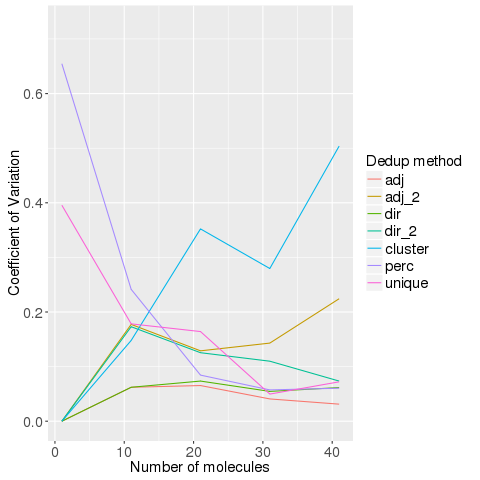

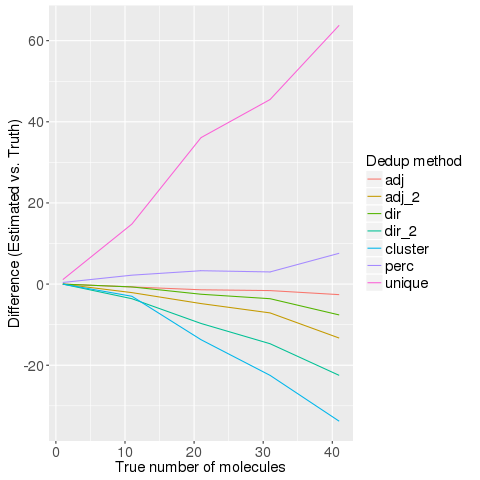

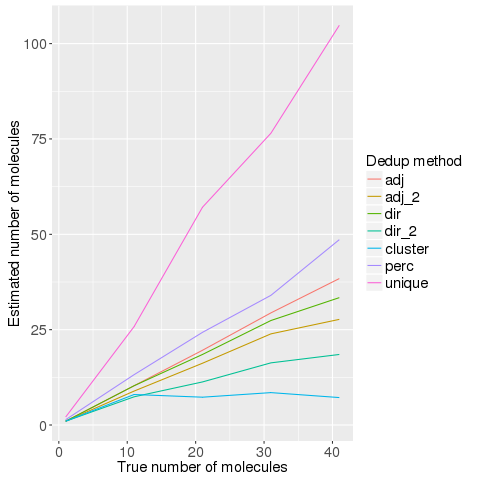

In [23]:
%%R -i df

library(ggplot2)

gg_color_hue <- function(n) {
  hues = seq(15, 375, length=n+1)
  hcl(h=hues, l=65, c=100)[1:n]
}

m_txt = element_text(size=15)

t = theme(axis.text.x = m_txt,
          axis.text.y = m_txt,
          axis.title.x = m_txt,
          axis.title.y = m_txt,
          legend.title = m_txt,
          legend.text = m_txt
         )

library(ggplot2)


df$dedup = factor(df$dedup, levels=c("adj", "adj_2", "dir", "dir_2",
                                     "cluster", "perc", "unique"))


p = ggplot(df, aes(x=number_of_molecules, y=CV, colour=dedup)) + 
geom_line() +
xlab("Number of molecules") +
ylab("Coefficient of Variation") +
scale_colour_manual(name="Dedup method", values=gg_color_hue(7)[1:7]) + 
t
print(p)

p = ggplot(df[df$dedup!="none",], aes(x=number_of_molecules, y=count-number_of_molecules, colour=dedup)) + 
geom_line() +
xlab("True number of molecules") +
ylab("Difference (Estimated vs. Truth)") +
scale_colour_manual(name="Dedup method", values=gg_color_hue(7)[1:7]) + 
t
print(p)

p = ggplot(df[df$dedup!="none",], aes(x=number_of_molecules, y=count, colour=dedup)) + 
geom_line() +
xlab("True number of molecules") +
ylab("Estimated number of molecules") +
scale_colour_manual(name="Dedup method", values=gg_color_hue(7)[1:7]) + 
t
print(p)

All looking good

Now let's repeat the simulations above but with greater numbers of iterations and varying each variable in turn then plot out for the manuscript.

We're going to want to repeat this process so let's build a class to perform the simulations and later some R functions for the plotting.

One last thing. It would be good to track the number and topology of clusters to see how the methods perform as the complexity increases...

In [24]:
def getClusterTopologies(Counter):

    def get_adj_list_cluster(umis):
        return {umi: [umi2 for umi2 in umis if edit_dist(umi, umi2) == 1] for umi in umis}

    def get_connected_components_cluster(graph, Counter):

        found = list()
        components = list()

        for node in sorted(graph, key=lambda x: Counter[x], reverse=True):
            if node not in found:
                component = breadth_first_search(node, graph)
                found.extend(component)
                components.append(component)

        return components

    def getTopologies(clusters, Counter):
    
        topologies = collections.Counter()
        nodes = 0

        for cluster in clusters:
            if len(cluster) == 1:
                topologies["single_node"] += 1
                nodes += 1
            else:
                most_con = max([len(adj_list[umi]) for umi in cluster])
                if most_con == (len(cluster)-1):
                    topologies["single_hub"] += 1
                    #topologies["single_hub"] += len(cluster)
                    nodes += len(cluster)
                else:
                    #topologies["complex"] += len(cluster)
                    topologies["complex"] += 1
                    nodes += len(cluster)

        return nodes, topologies
    
    
    adj_list = get_adj_list_cluster(Counter.keys())

    clusters = get_connected_components_cluster(adj_list, Counter)

    return getTopologies(clusters, Counter)

In [25]:
def sampleUMIs(final_UMIs, depth):
    len_final_UMIs = len(list(final_UMIs.elements()))
    
    assert depth > 0, "depth must be >0"
    assert depth <= len_final_UMIs, "depth must be greater than the number of UMIs"
    
    sampled_UMIs = np.random.choice(list(final_UMIs.elements()), depth)

    return collections.Counter(sampled_UMIs)

In [26]:
def getGroundTruth(UMIs_after_seq, UMIs):
    return len([x for x in UMIs_after_seq.keys() if x in UMIs])

print getGroundTruth(UMIs_after_seq, UMIs)

20


In [27]:
number_of_UMIs  = 10
length_of_UMIs = 6
efficiency_min, efficiency_max = (0.9, 1)
PCR_cycles = 4
error_rate = 0.00001
seq_error_rate = 0.01
sample_depth = 100

UMIs, efficiency_dict = createUMIsWithBias(number_of_UMIs, length_of_UMIs,
                                       efficiency_min, efficiency_max)
print len(UMIs)

final_UMIs = PCRcyclesWithErrorsAndBias(UMIs, efficiency_min, efficiency_max,
                                    efficiency_dict, PCR_cycles, error_rate)

print len(final_UMIs)

sampled_UMIs = sampleUMIs(final_UMIs, sample_depth)

print len(sampled_UMIs)

UMIs_after_seq = addSequencingErrors(sampled_UMIs, seq_error_rate)    

print len(UMIs_after_seq)

nodes, topologies = getClusterTopologies(UMIs_after_seq)


print getGroundTruth(UMIs_after_seq, UMIs)


print UMIs
print final_UMIs
print sampled_UMIs
print UMIs_after_seq


10
10
10
13
10
['TTACTG', 'TCTTTA', 'AGCTGA', 'ATTCTA', 'CGCGCT', 'CGCAGA', 'AGACGT', 'AGGTAA', 'GTATTA', 'GTACAT']
Counter({'ATTCTA': 16, 'TCTTTA': 16, 'AGACGT': 16, 'GTACAT': 16, 'CGCAGA': 16, 'GTATTA': 15, 'AGGTAA': 14, 'AGCTGA': 13, 'CGCGCT': 10, 'TTACTG': 4})
Counter({'GTACAT': 15, 'GTATTA': 14, 'AGACGT': 12, 'AGGTAA': 11, 'AGCTGA': 10, 'ATTCTA': 10, 'CGCGCT': 10, 'CGCAGA': 10, 'TCTTTA': 7, 'TTACTG': 1})
Counter({'GTACAT': 15, 'GTATTA': 13, 'AGACGT': 12, 'AGCTGA': 10, 'CGCGCT': 10, 'CGCAGA': 10, 'AGGTAA': 10, 'ATTCTA': 9, 'TCTTTA': 7, 'TTACTG': 1, 'AGGCAA': 1, 'GTGTTA': 1, 'AGTCTA': 1})


Now we redefine the "CountsPerMethod" function to inclue the topologies and the counts for networks without any true UMIs

In [28]:
def CountsPerMethod_plusTopologies(iterations, number_of_UMIs, length_of_UMIs, PCR_cycles,
                error_rate, seq_error_rate, efficiency_min, efficiency_max, sample_depth):
    
    no_dedup_results = []
    unique_dedup_results = []
    perc_dedup_results = []
    cluster_dedup_results = []
    adj_dedup_results = []
    dir_dedup_results = []
    adj_dedup2_results = []
    dir_dedup2_results = []
    node_count = []
    single_node =[]
    single_hub = []
    complex_network = []
    ground_truth = []
    no_true_umis_counts = collections.defaultdict(list)
    

    for x in range(0, iterations):

        UMIs, efficiency_dict = createUMIsWithBias(number_of_UMIs, length_of_UMIs,
                                                   efficiency_min, efficiency_max)

        final_UMIs = PCRcyclesWithErrorsAndBias(UMIs, efficiency_min, efficiency_max,
                                                efficiency_dict, PCR_cycles, error_rate)

        sampled_UMIs = sampleUMIs(final_UMIs, sample_depth)
        
        UMIs_after_seq = addSequencingErrors(sampled_UMIs, seq_error_rate) 
        
        ground_truth.append(getGroundTruth(UMIs_after_seq, UMIs))
        
        nodes, topologies = getClusterTopologies(UMIs_after_seq)
        node_count.append(nodes)
        single_node.append(topologies['single_node'])
        single_hub.append(topologies['single_hub'])
        complex_network.append(topologies['complex'])
        
        no_dedup_results.append(dedup_none(UMIs_after_seq))
        unique_dedup_results.append(dedup_unique(UMIs_after_seq))
        perc_dedup_results.append(dedup_percentile(UMIs_after_seq))
        
        cluster_count, cluster_no_true_networks, cluster_no_true_UMIs = dedup_cluster(UMIs_after_seq, UMIs)
        adj_count, adj_no_true_networks, adj_no_true_UMIs = dedup_adj(UMIs_after_seq, UMIs)
        dir_count, dir_no_true_networks, dir_no_true_UMIs = dedup_dir(UMIs_after_seq, UMIs)
        adj_count2, adj_no_true_networks2, adj_no_true_UMIs2 = dedup_adj(UMIs_after_seq, UMIs, 2)
        dir_count2, dir_no_true_networks2, dir_no_true_UMIs2 = dedup_dir(UMIs_after_seq, UMIs, 2)
        
        cluster_dedup_results.append(cluster_count)
        adj_dedup_results.append(adj_count)
        dir_dedup_results.append(dir_count)
        adj_dedup2_results.append(adj_count2)
        dir_dedup2_results.append(dir_count2)
        
        
        no_true_umis_counts["cluster_networks"].append(cluster_no_true_networks)
        no_true_umis_counts["cluster_umis"].append(cluster_no_true_UMIs)
        no_true_umis_counts["adjacency_networks"].append(adj_no_true_networks)
        no_true_umis_counts["adjacency_umis"].append(adj_no_true_UMIs)
        no_true_umis_counts["directional_networks"].append(dir_no_true_networks)
        no_true_umis_counts["directional_umis"].append(dir_no_true_UMIs)
        no_true_umis_counts["adjacency2_networks"].append(adj_no_true_networks2)
        no_true_umis_counts["adjacency2_umis"].append(adj_no_true_UMIs2)
        no_true_umis_counts["directional_networks"].append(dir_no_true_networks2)
        no_true_umis_counts["directional2_umis"].append(dir_no_true_UMIs2)
        
    
    counts = (no_dedup_results, unique_dedup_results, perc_dedup_results,
              cluster_dedup_results,
              adj_dedup_results, adj_dedup2_results,
              dir_dedup_results, dir_dedup2_results)
    
    return counts, node_count, single_node, single_hub, complex_network, ground_truth, no_true_umis_counts

In [29]:
def CV(counts):
    return np.std(counts)/np.mean(counts)
    
class simulatorWithVariable(object):
    
    def __init__(self,
                 iterations=1000,
                 umi_length=8,
                 pcr_cycles=6,
                 dna_pol_error_rate=-5,
                 seq_error_rate=-3,
                 eff_min=0.8,
                 eff_max=1.0,
                 number_of_umis=20,
                 sample_depth=100):
        
        self.iterations = iterations
        self.umi_length = umi_length
        self.pcr_cycles = pcr_cycles
        self.dna_pol_error_rate = dna_pol_error_rate
        self.seq_error_rate = seq_error_rate
        self.eff_min = eff_min
        self.eff_max = eff_max
        self.number_of_umis = number_of_umis
        self.sample_depth = sample_depth
        self.variable = None
    
    def updateVariable(self, variable=None):
        
        if variable == "umi_length":
            self.umi_length = self.variable
        elif variable == "pcr_cycles":
            self.pcr_cycles = self.variable
        elif variable == "dna_pol_error_rate":
            self.dna_pol_error_rate = self.variable
        elif variable == "seq_error_rate":
            self.seq_error_rate = self.variable
        elif variable == "eff_min":
            self.eff_min = self.variable
        elif variable == "eff_max":
            self.eff_max = self.variable
        elif variable == "number_of_umis":
            self.number_of_umis = self.variable
        elif variable == "sample_depth":
            self.sample_depth = self.variable

    def iterator(self, variable, variable_min, variable_max, variable_step):
        assert variable, "need to specify variable"       
        
        dedup_methods = ["none", "unique", "percentile", "cluster",
                         "adjacency", "adjacency2", "directional", "directional2"]
        
        df = pd.DataFrame()
        
        variable_range = np.arange(variable_min, variable_max, variable_step)
        print_step = len(variable_range)/10.0
    
        n = 0
        for value in variable_range:

            self.variable = value
            self.updateVariable(variable)
            pol_error_rate = 10**self.dna_pol_error_rate
            seq_error_rate = 10**self.seq_error_rate
            
            (counts, nodes, single_node, single_hub,
             complex_network, ground_truth, no_true_umis_counts) = CountsPerMethod_plusTopologies(
                self.iterations, self.number_of_umis,
                self.umi_length, self.pcr_cycles,
                pol_error_rate, seq_error_rate,
                self.eff_min, self.eff_max,
                self.sample_depth)
            
            difference = []
            norm_difference = []

            no_true_umis_networks = []
                    
            tmp_df = pd.DataFrame({"variable": (self.variable,)*len(dedup_methods),
                                   'dedup':dedup_methods,
                                   'count':[np.mean(x) for x in counts],
                                   'no_true_umi_networks':[np.mean(no_true_umis_counts["%s_networks" % x])
                                       for x in dedup_methods],
                                   'no_true_umis':[np.mean(no_true_umis_counts["%s_umis" % x])
                                       for x in dedup_methods],
                                   'truth': (np.mean(ground_truth),) * len(dedup_methods),
                                   'CV':[CV(x) for x in counts],
                                   'nodes': np.mean(nodes)*len(dedup_methods),
                                   'single_node':np.mean(single_node,)*len(dedup_methods),
                                   'single_hub':np.mean(single_hub,)*len(dedup_methods),
                                   'complex': np.mean(complex_network,)*len(dedup_methods)})
            df = df.append(tmp_df)
            n +=1 
            
            print strftime("%Y-%m-%d %H:%M:%S", gmtime()), "%d %% complete: %s=%d" % (
                np.divide(float(n*100), len(variable_range)), variable, value)

        df['difference'] = df['count'] / df['truth']
        return df

"Normal" values - these are set in the simulatorWithVariable class:

* umi_length = 6
    - length of UMI
    
* pcr_cycles = 10
    - number of PCR cycles
    
* dna_pol_error_rate = -5
    - error rate for DNA pol in PCR amplification (log10)
    
* seq_error_rate = -3
    - error rate for base calling in sequencing (log10)
    
* eff_min = 0.9
    - minimum efficiency of amplification in PCR
    
* eff_max = 1.0
    - maximum efficiency of amplification in PCR
    
* number_of_umis = 25
    - number of initial unique fragments/UMIs


In [30]:
# This will take <1 hour with iterations = 1000
iterations = 10000
sim = simulatorWithVariable(iterations=iterations)
df_sample_depth = sim.iterator("sample_depth", 20, 401, 10)
df_sample_depth.to_csv(os.path.join(wd, "simulation_seq_depth.tsv"), sep="\t", index=False)

sim = simulatorWithVariable(iterations=iterations)
df_UMI_length = sim.iterator("umi_length", 4, 17, 1)
df_UMI_length.to_csv(os.path.join(wd, "simulation_umi_length.tsv"), sep="\t", index=False)

sim = simulatorWithVariable(iterations=iterations)
df_Number_of_Molecules = sim.iterator("number_of_umis", 10, 101, 10)
df_Number_of_Molecules.to_csv(os.path.join(wd, "simulation_number_molecules.tsv"), sep="\t", index=False)

sim = simulatorWithVariable(iterations=iterations)
df_PCR_cycles = sim.iterator("pcr_cycles", 4, 17, 1)
df_PCR_cycles.to_csv(os.path.join(wd, "simulation_pcr_cycles.tsv"), sep="\t", index=False)

sim = simulatorWithVariable(iterations=iterations)
df_DNA_pol_error_rate = sim.iterator("dna_pol_error_rate", -7, -2.01, 0.1)
df_DNA_pol_error_rate.to_csv(os.path.join(wd, "simulation_dna_pol_error_rate.tsv"), sep="\t", index=False)

sim = simulatorWithVariable(iterations=iterations)
df_Sequencing_error_rate = sim.iterator("seq_error_rate", -5, -0.9, 0.1)
df_Sequencing_error_rate.to_csv(os.path.join(wd, "simulation_seq_error_rate.tsv"), sep="\t", index=False)

sim = simulatorWithVariable(iterations=iterations)
df_Minimum_amplification_efficiency = sim.iterator("eff_min", 0.1, 1, 0.02)
df_Minimum_amplification_efficiency.to_csv(os.path.join(wd, "simulation_min_eff.tsv"), sep="\t", index=False)

/ifs/apps/apps/python-2.7.11-gcc-5.2.1/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


2016-11-08 11:08:47 2 % complete: sample_depth=20
2016-11-08 11:08:47 5 % complete: sample_depth=30
2016-11-08 11:08:47 7 % complete: sample_depth=40
2016-11-08 11:08:47 10 % complete: sample_depth=50
2016-11-08 11:08:48 12 % complete: sample_depth=60
2016-11-08 11:08:48 15 % complete: sample_depth=70
2016-11-08 11:08:48 17 % complete: sample_depth=80
2016-11-08 11:08:48 20 % complete: sample_depth=90
2016-11-08 11:08:48 23 % complete: sample_depth=100
2016-11-08 11:08:48 25 % complete: sample_depth=110
2016-11-08 11:08:48 28 % complete: sample_depth=120
2016-11-08 11:08:48 30 % complete: sample_depth=130
2016-11-08 11:08:48 33 % complete: sample_depth=140
2016-11-08 11:08:49 35 % complete: sample_depth=150
2016-11-08 11:08:49 38 % complete: sample_depth=160
2016-11-08 11:08:49 41 % complete: sample_depth=170
2016-11-08 11:08:49 43 % complete: sample_depth=180
2016-11-08 11:08:49 46 % complete: sample_depth=190
2016-11-08 11:08:49 48 % complete: sample_depth=200
2016-11-08 11:08:49 51 

## If you've already run the simulations, you can start the plotting from here

In [31]:
df_sample_depth = pd.read_csv(os.path.join(wd, "simulation_seq_depth.tsv"), sep="\t")

df_UMI_length = pd.read_csv(os.path.join(wd, "simulation_umi_length.tsv"), sep="\t")

df_PCR_cycles = pd.read_csv(os.path.join(wd, "simulation_pcr_cycles.tsv"), sep="\t")

df_DNA_pol_error_rate = pd.read_csv(os.path.join(wd, "simulation_dna_pol_error_rate.tsv"), sep="\t")

df_Sequencing_error_rate = pd.read_csv(os.path.join(wd, "simulation_seq_error_rate.tsv"), sep="\t")

df_Minimum_amplification_efficiency = pd.read_csv(os.path.join(wd, "simulation_min_eff.tsv"), sep="\t")

df_Number_of_Molecules = pd.read_csv(os.path.join(wd, "simulation_number_molecules.tsv"), sep="\t")

For the plots below, all but one variables are held constant. The value for that variable in the other plots is represented by the dashed red line. The top panel compares the methods, the bottom panel additionally shows the metrics prior to deduplication. The left panel shows the difference between the estimated number of unique fragments and the ground truth, the right panel shows the coefficient of variation (sd/mean).

In [32]:
%%R 
plot_simulations = function(df, plot_dir , difference=FALSE, log=FALSE, umi_count=FALSE, variable, xlab="",
                            xint=TRUE, xvert=FALSE, breaks=seq(0,1,1), network_breaks=NA, y_breaks=NA,
                            difference_y_breaks=NA,
                            no_true_y_breaks=NA,
                            network_y_breaks=NA, cv_y_breaks=NA,
                            complex_network_breaks=NA,
                            plot_difference_networks=FALSE,
                            plot_difference_complex_networks=FALSE,
                            plot_truth_networks=FALSE,
                            plot_variable_name=FALSE,
                            plot_no_true_networks=FALSE){
    library(ggplot2)
    library(reshape)
    library(gridExtra)
    library(grid)
    library(plyr)
    library(cowplot)
    
    if(plot_variable_name!=FALSE){
        plot_variable_name = plot_variable_name
    }
    
    else{
        plot_variable_name = variable
    }
    
    get_legend<-function(myggplot){
    tmp <- ggplot_gtable(ggplot_build(myggplot))
    leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
    legend <- tmp$grobs[[leg]]
    return(legend)
    }

    df$fraction_network = 1-(df$single_node/df$nodes)
    df$fraction_complex_network = df$complex/df$nodes
                        

    gg_color_hue <- function(n) {
      hues = seq(20, 380, length=n+1)
      hcl(h=hues, l=75, c=100)[1:n]
    }
                        
     gg_color_hue <- function(n) {
         colours = c("black", "grey70", "#F0E442", "#009E73", "#CC79A7",
                  "#E69F00", "#0072B2", "#D55E00")
        return(colours[1:n])}

    m_txt = element_text(size=30)
    l_txt = element_text(size=30)

    t = theme_cowplot() + 
        theme(axis.text.x = m_txt,
              axis.text.y = m_txt,
              axis.title.x = m_txt,
              axis.title.y = element_text(size = 30),
              legend.title = l_txt,
              legend.text = l_txt,
              legend.key = element_blank(),
              legend.key.width=unit(3,"line"),
              legend.key.height=unit(2,"line"),
              aspect.ratio=1)

    
    df$dedup = factor(df$dedup, levels=c("unique", "percentile",
                                         "cluster", "adjacency", "directional",
                                         "adjacency2", "directional2","none"))
                        
    df$dedup = revalue(df$dedup,c("adjacency" = "Adjacency", "adjacency2" = "Adjacency (2)",
                                  "directional" = "Directional", "directional2" = "Directional (2)",
                                  "cluster" = "Cluster", "percentile" = "Percentile",
                                  "unique" = "Unique", "none" = "None"))

    df$Threshold = df$dedup %in% c("Adjacency (2)", "Directional (2)")
    df$Threshold = as.factor(ifelse(df$Threshold==1, 2, 1))
                        
    plot_CV = function(df, double_thresh=FALSE){
        
        if(double_thresh){
        p = ggplot(df, aes(x=variable, y=CV, colour=dedup, linetype=Threshold))
        }
        else{
        p = ggplot(df, aes(x=variable, y=CV, colour=dedup))
        }
        p = p + 
        geom_line(size=2) + 
        ylab("Coefficient of Variation")
        
        return(p)
    }
                        
    plot_difference = function(df, double_thresh=FALSE){
            
        if(double_thresh){
        p = ggplot(df, aes(x=variable, y=log(difference,2), colour=dedup, linetype=Threshold))
        }
        else{
        p = ggplot(df, aes(x=variable, y=log(difference,2), colour=dedup))
        }
        p = p + 
        geom_abline(size=1, slope=0, alpha=0.5, linetype=2, colour="grey50") +
        geom_line(size=2) +         
        ylab("Log2 (Estimate - Truth) / Truth")
        
        return(p)
    }
                        
    plot_truthEstimate = function(df, double_thresh=FALSE){
            
        if(double_thresh){
        p = ggplot(df, aes(x=truth, y=count, colour=dedup, linetype=Threshold))
        }
        else{
        p = ggplot(df, aes(x=truth, y=count, colour=dedup))
        }
        
        p = p +        
        geom_abline(size=1, slope=1, alpha=0.5, linetype=2, colour="grey50") +
        geom_line(size=2) +         
        ylab("Estimate")
        return(p)
    }
    
                        
    plot_network_difference = function(df){
        p = ggplot(df, aes(x=100*fraction_network, y=log(difference,2), colour=dedup)) +
        geom_line(size=2) +
        ylab("Log2 (Estimate - Truth) / Truth") +
        xlim(0, max(100*df$fraction_network))
        return(p)}
                        
    plot_network_difference_complex = function(df){
        p = ggplot(df, aes(x=100*fraction_complex_network, y=log(difference,2), colour=dedup)) +
        geom_line(size=2) +
        ylab("Log2 (Estimate - Truth) / Truth") +
        xlim(0, max(100*df$fraction_network))
        return(p)}
                        
    plot_network = function(df){
        p  = ggplot(df[df$dedup %in% c("Adjacency", "Directional", "Cluster", "Percentile", "Unique"),],
                    aes(y=100*fraction_network, x=variable)) +
        geom_line(size=2) +
        ylab("Networks (%)")
        return(p)}

    plot_no_true_umi_networks = function(df){
        p  = ggplot(df[df$dedup %in% c("Adjacency", "Directional", "Adjacency (2)", "Directional (2)"),],
                    aes(y=no_true_umi_networks, x=variable, colour=dedup, linetype=Threshold)) +
    
        geom_line(size=1) +
        ylab("Networks without any true UMIs")
        return(p)}                        
                        
    make_pretty = function(p, n_features, xint, xlab, xvert, ybreaks=NA,
                           colour_start=1, double_thresh=FALSE, limit=FALSE){

        if (double_thresh){
        p = p + scale_colour_manual(name="Method", values=c(gg_color_hue(7)[c(3,4,5,4,5)])) +
        xlab(xlab) + t
        }
        
        else{
        p = p + scale_colour_manual(name="Method", values=c(gg_color_hue(7)[colour_start:n_features])) +
        guides(colour = guide_legend(override.aes = list(size=2))) + xlab(xlab) + t +
        theme(legend.justification = c(0, 1), legend.position = c(0, 1))
        }
        
        if(xint==TRUE){
            breaks = seq(min(df$variable), max(df$variable), 1)           
        }
        
        if(xvert!=FALSE){
            p = p +
            geom_vline(xintercept = xvert, colour="red", linetype = "longdash", size=0.5)}
        
        if(!is.na(ybreaks)){
            if(limit==TRUE){
                p = p + 
                t + scale_y_continuous(breaks=ybreaks, limits=c(min(ybreaks), max(ybreaks)))
            }
            else{
                p = p + 
                t + scale_y_continuous(breaks=ybreaks) +
                expand_limits(y=max(ybreaks))
                }
        }
        
        
        p = p + scale_x_continuous(breaks=breaks) 
        return(p)
    }
                               
    make_pretty_network = function(p, n_features, xlab, breaks, ybreaks=NA,
                                   xvert=FALSE, xint=FALSE, set_int=FALSE, colour_start=1){

        p = p +
        xlab(xlab) +
        guides(colour = guide_legend(override.aes = list(size=2))) +
        t + scale_x_continuous(breaks=breaks, limits=c(min(breaks), max(breaks))) 
        
        if(n_features==2){
            p = p + scale_colour_manual(name="Method", values=c(gg_color_hue(6)[4:5]))}
        else if(n_features==4){
            p = p + scale_colour_manual(name="Method", values=c(gg_color_hue(6)[c(4,5,4,5)]))}
        else{
            p = p + scale_colour_manual(name="Method", values=c(gg_color_hue(6)[colour_start:n_features]))
        }
        
       
        if(xvert!=FALSE){
            p = p +
            geom_vline(xintercept = xvert, colour="red", linetype = "longdash", size=0.5)}
        
        if(!is.na(ybreaks)){
            p = p + scale_y_continuous(breaks=ybreaks, limits=c(min(ybreaks), max(ybreaks)))
        }
        
        if(xint==TRUE & set_int==TRUE){
            breaks = seq(min(df$variable), max(df$variable), 1)           
        }
        
        p = p + scale_x_continuous(breaks=breaks)
        
        return(p)
    }
                        
                        
    p1 = plot_CV(df[df$dedup %in% c("Adjacency", "Directional", "Cluster", "Percentile", "Unique"),])
    p1 = make_pretty(p1, 5, xint, xlab, xvert, ybreaks=cv_y_breaks, limit=TRUE)
    
    if(difference==TRUE){
        p2 = plot_difference(df[df$dedup %in% c("Adjacency", "Directional", "Cluster", "Percentile", "Unique"),])
        p2 = make_pretty(p2, 5, xint, xlab, xvert, ybreaks=y_breaks)}

    else{
        p2 = plot_truthEstimate(df[df$dedup %in% c("Adjacency", "Directional", "Cluster", "Percentile", "Unique"),])
        p2 = make_pretty(p2, 5, xint, xlab, xvert, ybreaks=y_breaks)}
     
    p3 = plot_network_difference(df[df$dedup %in% c("Adjacency", "Directional", "Cluster", "Percentile", "Unique"),])
    p3 = make_pretty_network(p3, 5, xlab="Networks (%)",
                             network_breaks, ybreaks=difference_y_breaks)

    p4 = plot_network(df[df$dedup %in% c("Adjacency", "Directional", "Cluster", "Percentile", "Unique"),])
    p4 = make_pretty_network(p4, 5, xlab=xlab, breaks,
                             xvert=xvert, ybreaks=network_y_breaks,
                             xint=xint, set_int=TRUE)

    p5 = plot_network_difference_complex(df[df$dedup %in% c("Adjacency", "Directional",
                                                            "Cluster", "Percentile", "Unique"),])
    p5 = make_pretty_network(p5, 5, xlab="Complex networks (%)",
                             breaks=complex_network_breaks,
                             ybreaks=difference_y_breaks, xint=xint)
    
    p6 = plot_no_true_umi_networks(df[df$dedup %in%
                                      c("Adjacency", "Directional", "Adjacency (2)", "Directional (2)"),])
    p6 = make_pretty_network(p6, 4, xlab=xlab, breaks=breaks, ybreaks=no_true_y_breaks,
                             xvert=xvert, xint=xint, set_int=TRUE)
                        
                        
    p2 = p2 + theme(legend.position="right")             
    p3 = p3 + theme(legend.position="right")
    p4 = p4 + theme(legend.position="right")                    
    p5 = p5 + theme(legend.position="right")
    p6 = p6 + theme(legend.position="right")

    print(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_deduped.svg"))
    svg(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_deduped.svg"), width=10, height=7)
    print(p2)
    dev.off()
    png(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_deduped.png"),
        width=30, height=21, unit="cm", res=400)
    print(p2)
    dev.off()                        
    print(p2)


    if(plot_difference_networks==TRUE){
        svg(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_networks.svg"),
            width=10, height=7)
        print(p3)
        dev.off()
        
        png(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_networks.png"),
            width=30, height=21, unit="cm", res=400)
        print(p3)
        dev.off()
        
        print(p3)
        }
    
    if(plot_truth_networks==TRUE){                        
        svg(paste0(plot_dir,"simulation_", plot_variable_name, "_ground_truth_networks.svg"),
            width=10, height=7)
        print(p4)
        dev.off()
        
        png(paste0(plot_dir,"simulation_", plot_variable_name, "_ground_truth_networks.png"),
            width=30, height=21, unit="cm", res=400)
        print(p4)
        dev.off()
        
        print(p4)
    }

    if(plot_difference_complex_networks==TRUE){
        svg(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_complex_networks.svg"),
            width=10, height=7)
        print(p5)
        dev.off()
        
        png(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_complex_networks.png"),
           width=30, height=21, unit="cm", res=400)
        print(p5)
        dev.off()
        
        print(p5)
        }

    if(plot_no_true_networks==TRUE){
        svg(paste0(plot_dir,"simulation_", plot_variable_name, "_no_true_umi_networks.svg"),
            width=10, height=7)
        print(p6)
        dev.off()
        
        png(paste0(plot_dir,"simulation_", plot_variable_name, "_no_true_umi_networks.png"),
           width=30, height=21, unit="cm", res=400)
        print(p6)
        dev.off()
        
        print(p6)
        }

        
    plot_legend = get_legend(p1)
    p1 = p1 + theme(legend.position="none")                        
    p2 = p2 + theme(legend.position="none")

    blank<-rectGrob(gp=gpar(col="white"))
        
    png(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_cv_deduped.png"),
        width=50, height=21, unit="cm", res=400)
    grid.arrange(p2, blank, p1, plot_legend, ncol=4, widths=c(0.39, 0.02, 0.39, 0.2))
    dev.off()
    grid.arrange(p2, blank, p1, plot_legend, ncol=4, widths=c(0.39, 0.02, 0.39, 0.2))

    p1 = plot_CV(df[df$dedup %in% c(
            "Adjacency", "Adjacency (2)", "Directional", "Directional (2)",  "Cluster"),],
                 double_thresh=TRUE)
    p1 = make_pretty(p1, 7, xint, xlab, xvert, colour_start=3, double_thresh=TRUE,
                     ybreaks=cv_y_breaks, limit=TRUE)
    
    if(difference==TRUE){
        p2 = plot_difference(df[df$dedup %in% c(
            "Adjacency", "Adjacency (2)", "Directional", "Directional (2)",  "Cluster"),],
                             double_thresh=TRUE)
        print(p2)
        p2 = make_pretty(p2, 7, xint, xlab, xvert, ybreaks=y_breaks,
                         colour_start=3, double_thresh=TRUE, limit=TRUE)
        print(p2)}
                        
    else{
        p2 = plot_truthEstimate(df[df$dedup %in% c(
            "Adjacency", "Adjacency (2)", "Directional", "Directional (2)",  "Cluster"),],
                                double_thresh=TRUE)
        p2 = make_pretty(p2, 7, xint, xlab, xvert, ybreaks=y_breaks,
                         colour_start=3, double_thresh=TRUE, limit=TRUE)}
    
    plot_legend = get_legend(p1)
    
    p1 = p1 + theme(legend.position="none")
    p2 = p2 + theme(legend.position="none")             
    
                        
    png(paste0(plot_dir,"simulation_", plot_variable_name, "_difference_cv_all.png"),
        width=50, height=21, unit="cm", res=400)
    grid.arrange(p2, blank, p1, plot_legend, ncol=4, widths=c(0.37, 0.06, 0.37, 0.2))
    dev.off()
                        
    grid.arrange(p2, blank, p1, plot_legend, ncol=4, widths=c(0.37, 0.06, 0.37, 0.2))
}

/ifs/apps/apps/python-2.7.11-gcc-5.2.1/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: 'plyr'


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/ifs/apps/apps/python-2.7.11-gcc-5.2.1/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from 'package:reshape':

    rename, round_any


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/ifs/apps/apps/python-2.7.11-gcc-5.2.1/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: 'cowplot'


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/ifs/apps/apps/python-2.7.11-gcc-5.2.1/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from 'package:ggplot2':

    ggsave


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/ifs/apps/apps/python-2.7.11-gcc-5.2.1/lib/python2.7/site-packages/rpy2/robjects/fun

[1] "../figures.dir/simulation_number_of_umis_difference_deduped.svg"


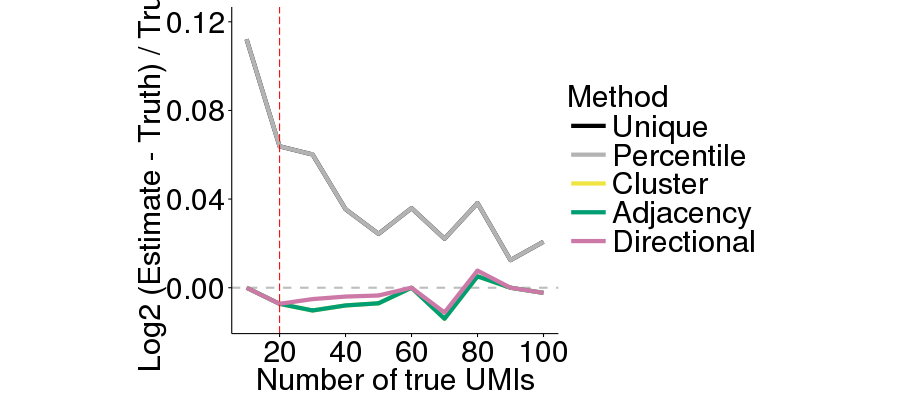

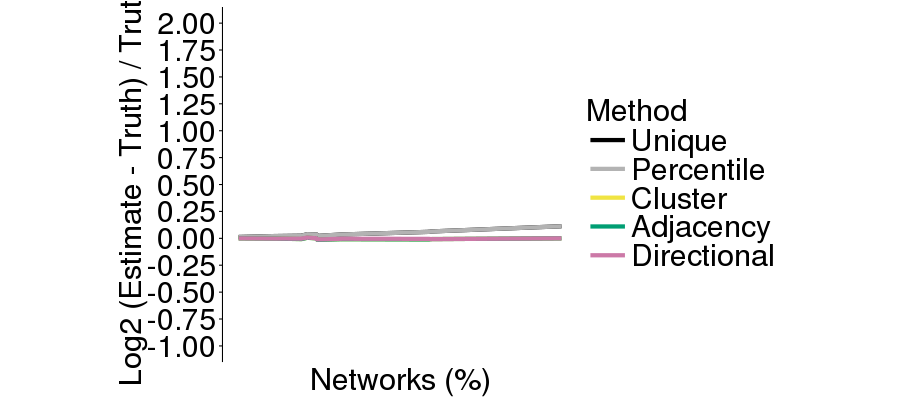

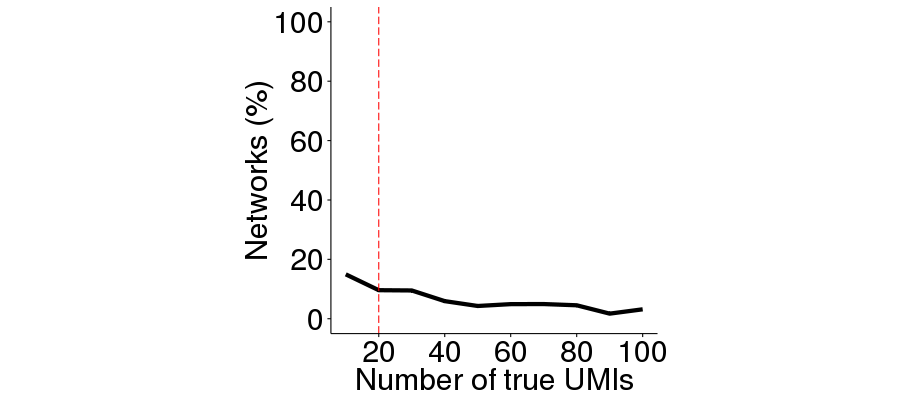

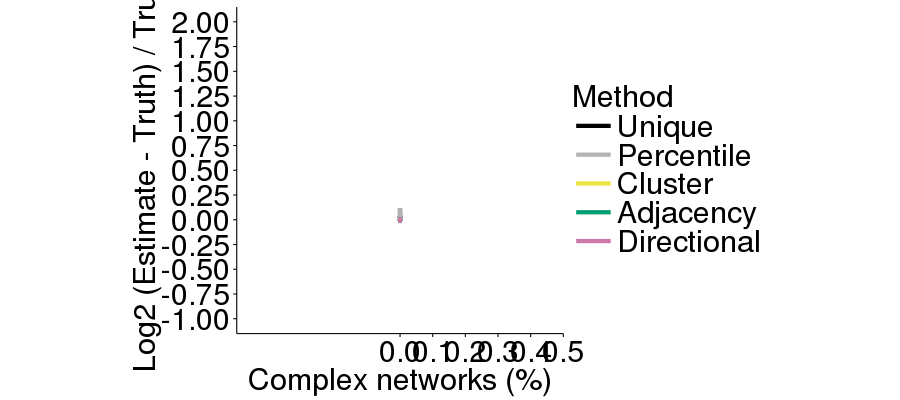

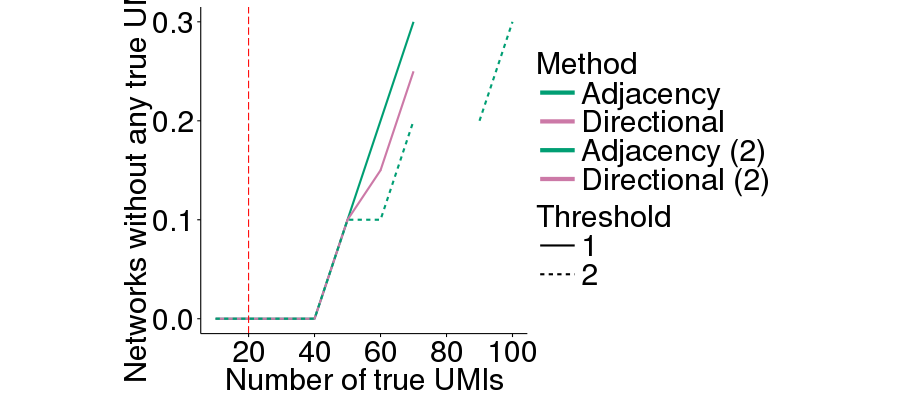

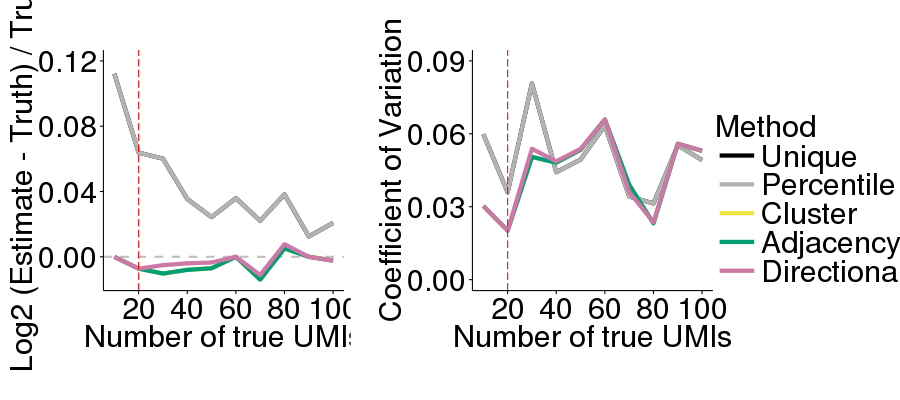

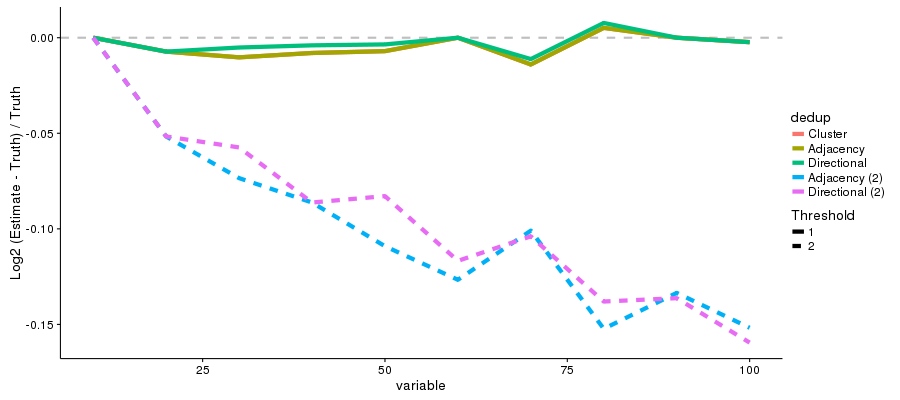

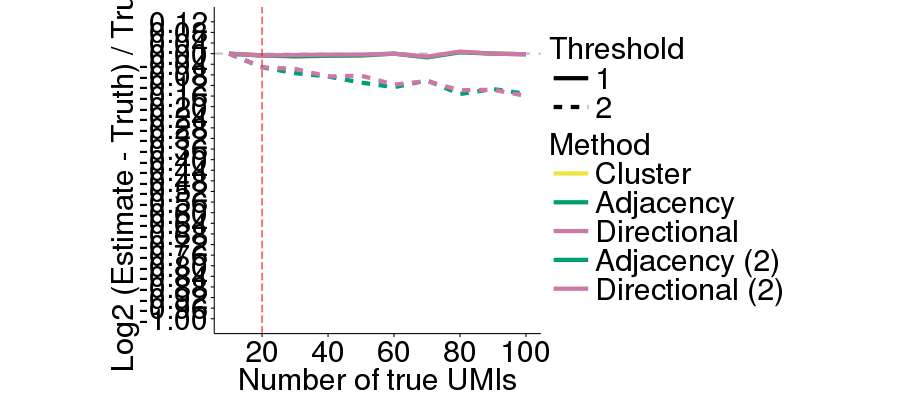

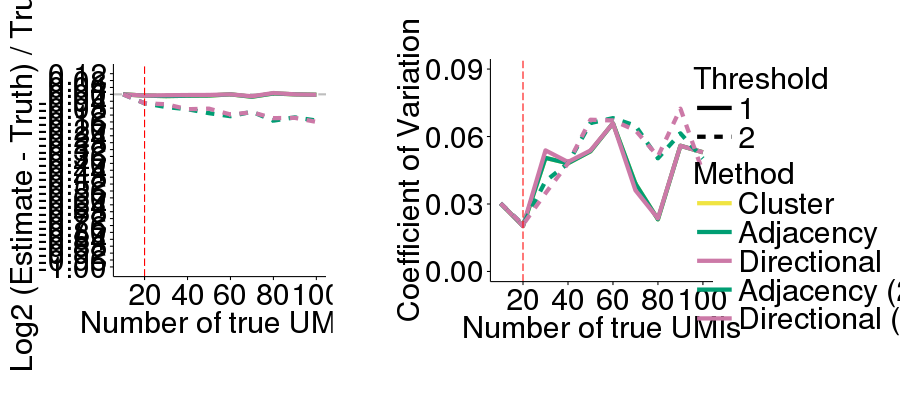

In [33]:
%%R -i df_Number_of_Molecules  -w 900 -h 400 -u px
breaks = seq(0, 100, 20)
network_breaks = seq(0, 100, 20)
plot_simulations(df_Number_of_Molecules, plotdir, difference=TRUE, umi_count=20,
                 variable="number_of_umis", xlab="Number of true UMIs",
                 xint=FALSE,
                 breaks=breaks,
                 network_breaks=network_breaks,
                 xvert=20,
                 difference_y_breaks=seq(-1,2,0.25),
                 y_breaks=seq(-1,0.12,0.04),
                 network_y_breaks=network_breaks,
                 no_true_y_breaks=seq(0, 0.3, 0.1),
                 cv_y_breaks=seq(0, 0.09, 0.03),
                 complex_network_breaks=seq(0,4,0.1),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE)

[1] "../figures.dir/simulation_sample_depth_difference_deduped.svg"


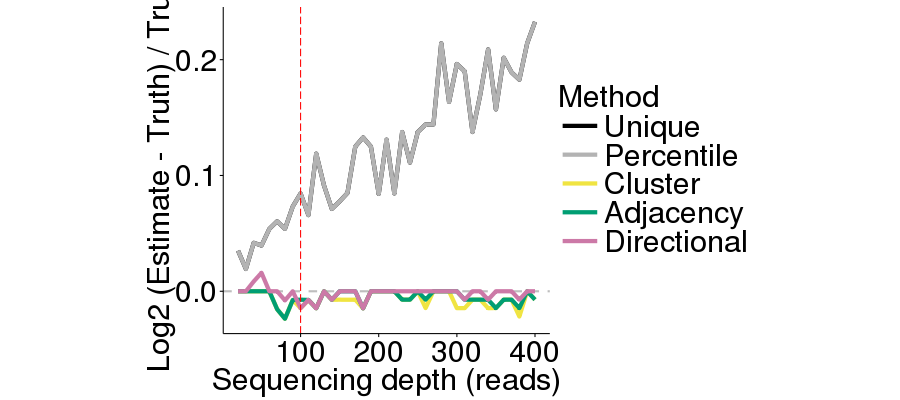

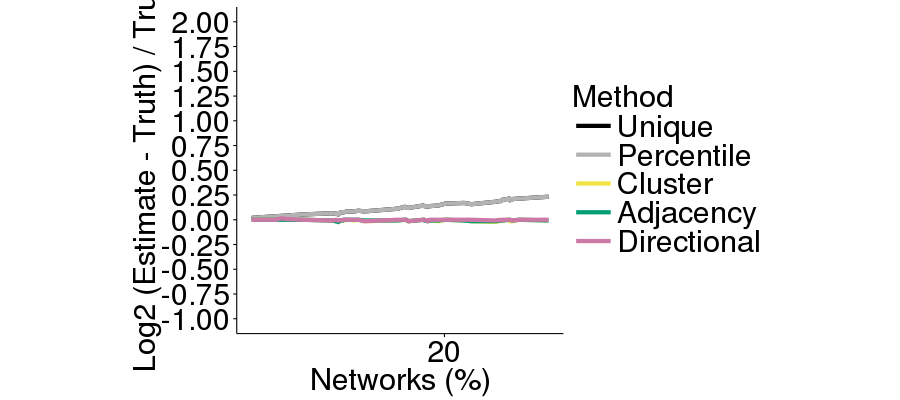

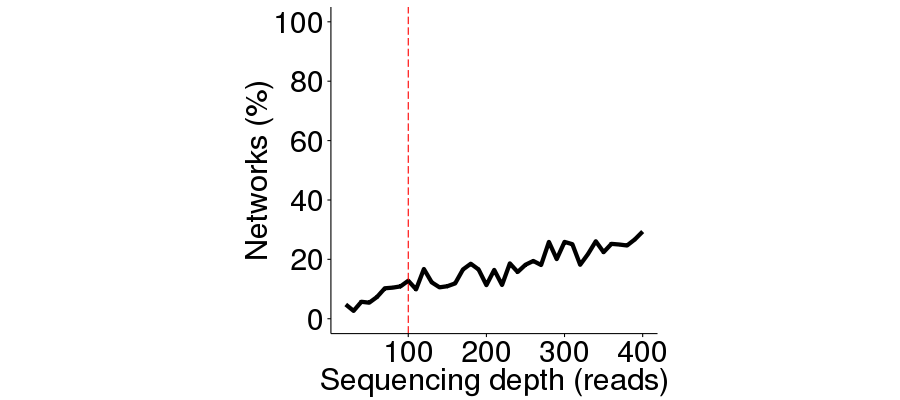

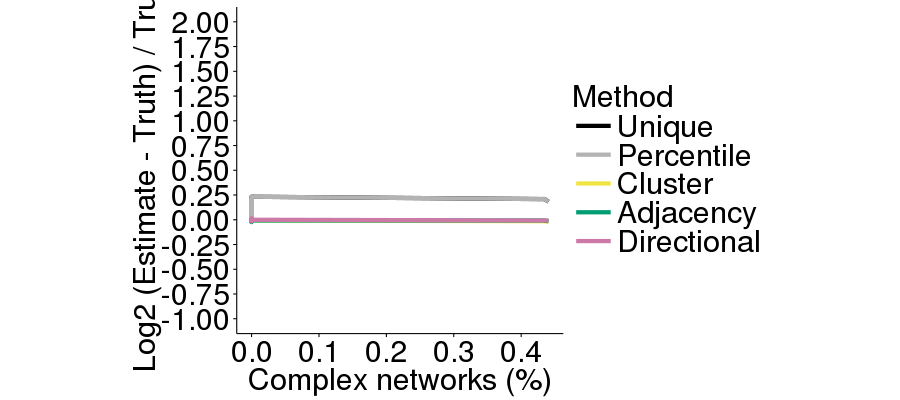

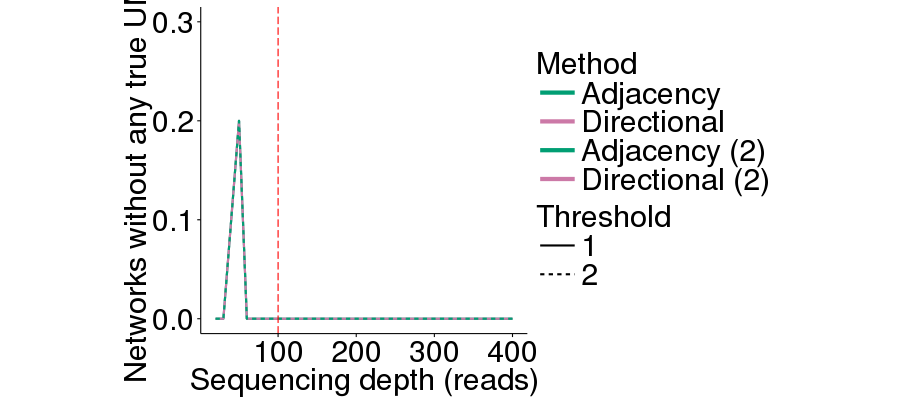

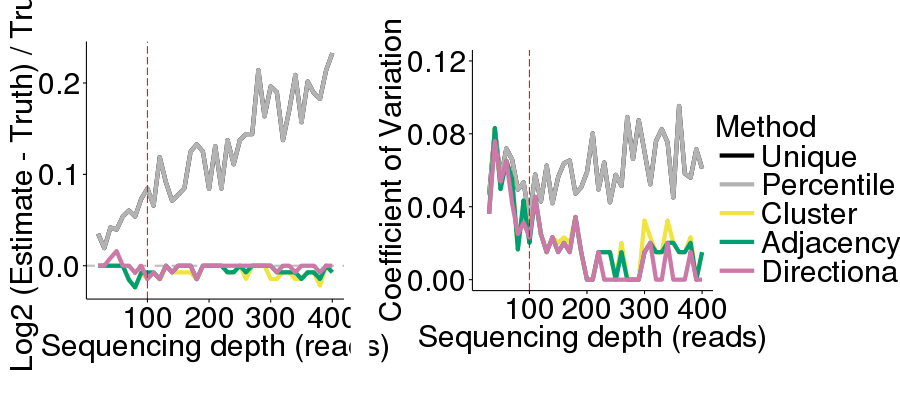

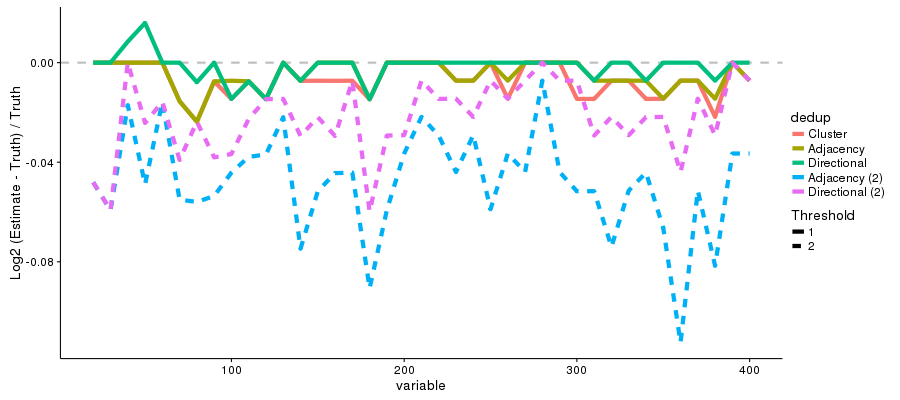

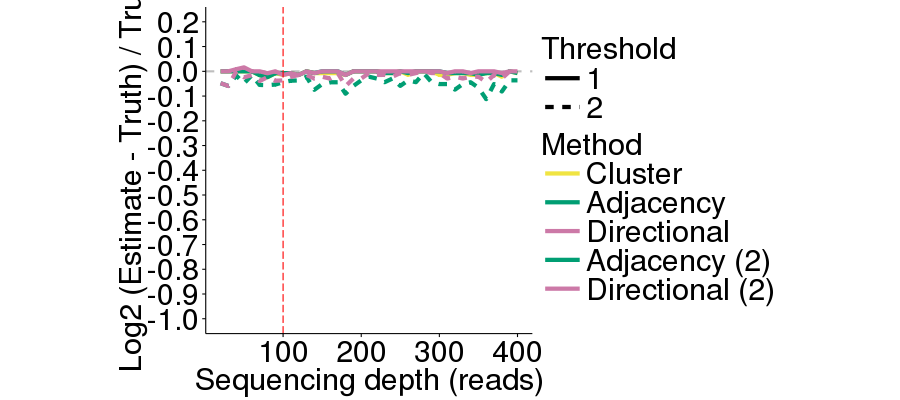

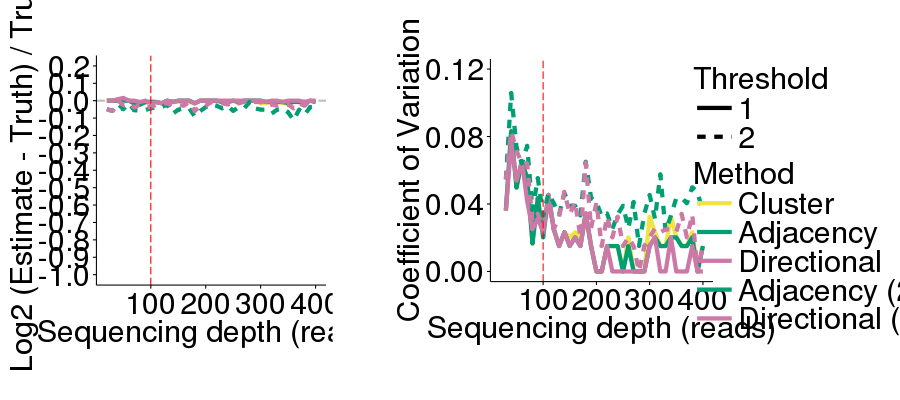

In [34]:
%%R -i df_sample_depth   -w 900 -h 400 -u px
breaks = seq(0, 400, 100)
network_breaks = seq(0, 100, 20)
plot_simulations(df_sample_depth, plotdir, difference=TRUE, umi_count=20,
                 variable="sample_depth", xlab="Sequencing depth (reads)",
                 xint=FALSE, breaks=breaks, network_breaks=network_breaks,
                 xvert=100, difference_y_breaks=seq(-1,2,0.25),
                 y_breaks=seq(-1,0.25,0.1),
                 network_y_breaks=network_breaks,
                 no_true_y_breaks=seq(0, 0.3, 0.1),
                 cv_y_breaks=seq(0, 0.12, 0.04),
                 complex_network_breaks=seq(0,4,0.1),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE)

[1] "../figures.dir/simulation_umi_length_xintercept_difference_deduped.svg"


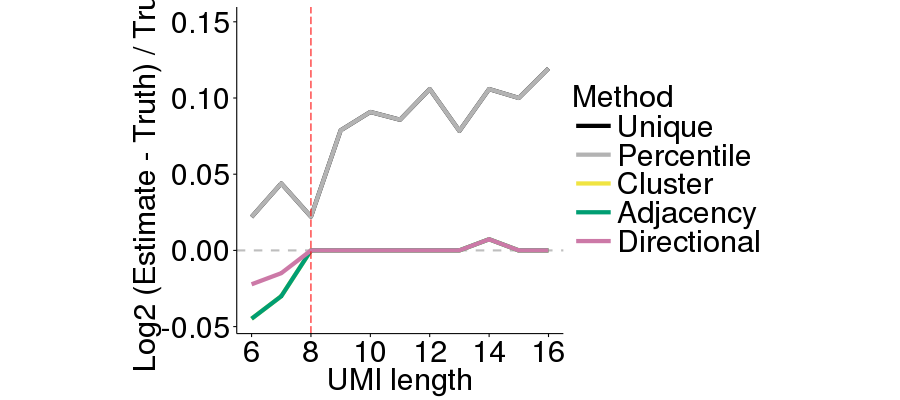

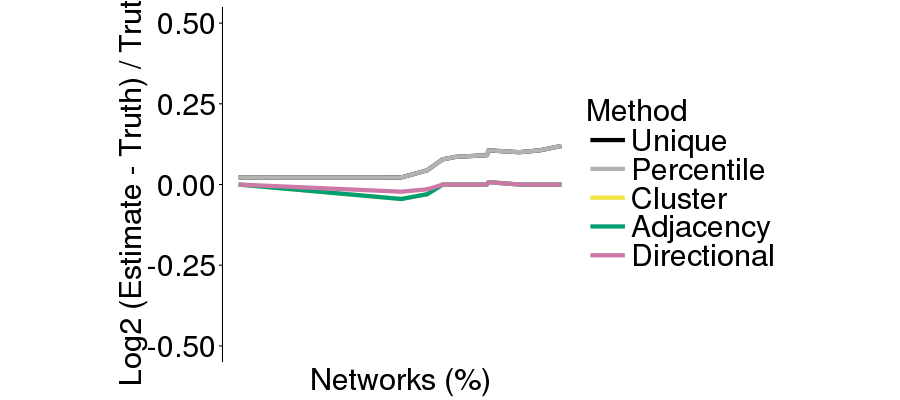

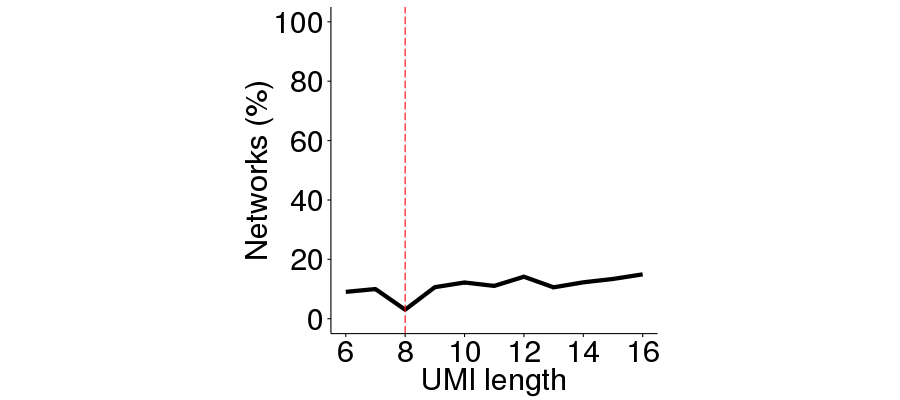

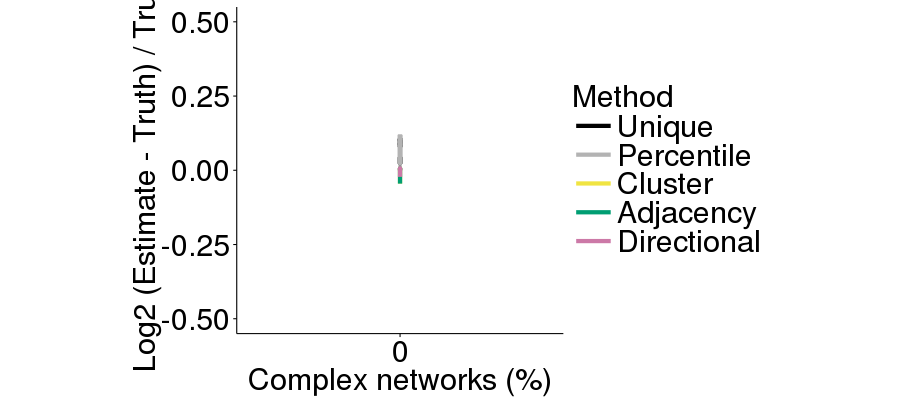

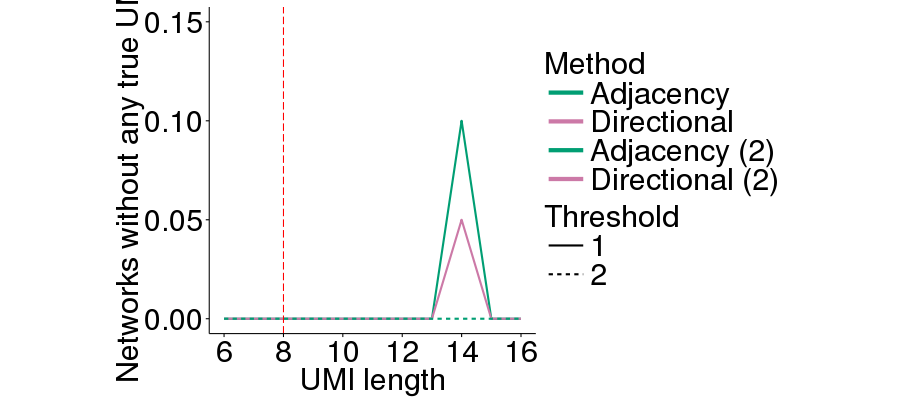

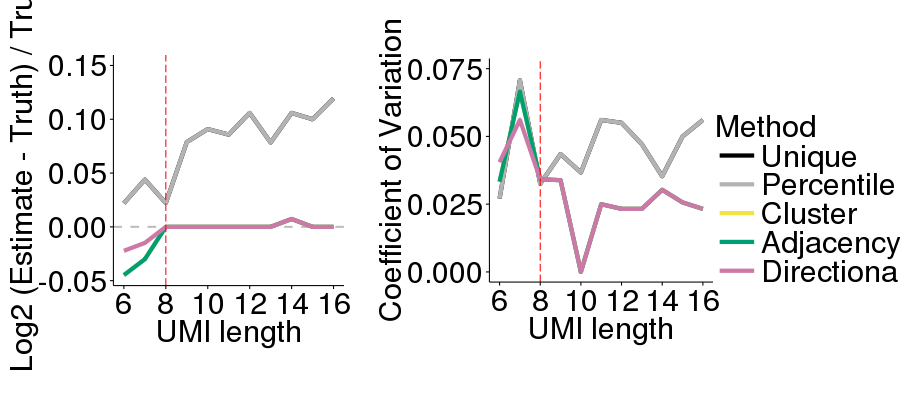

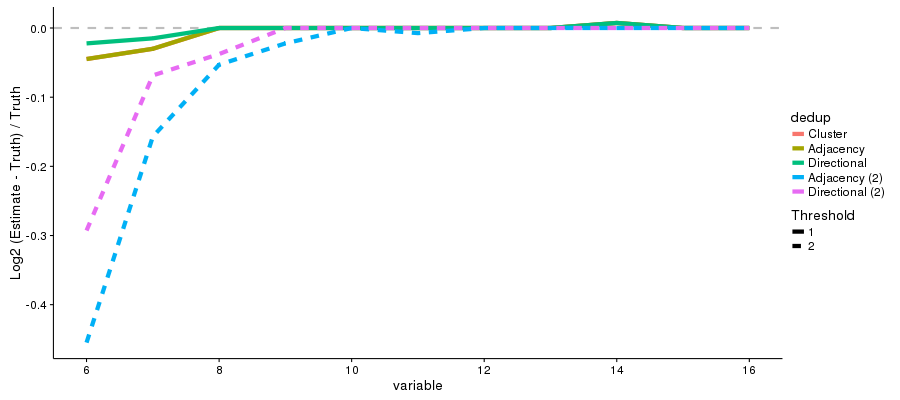

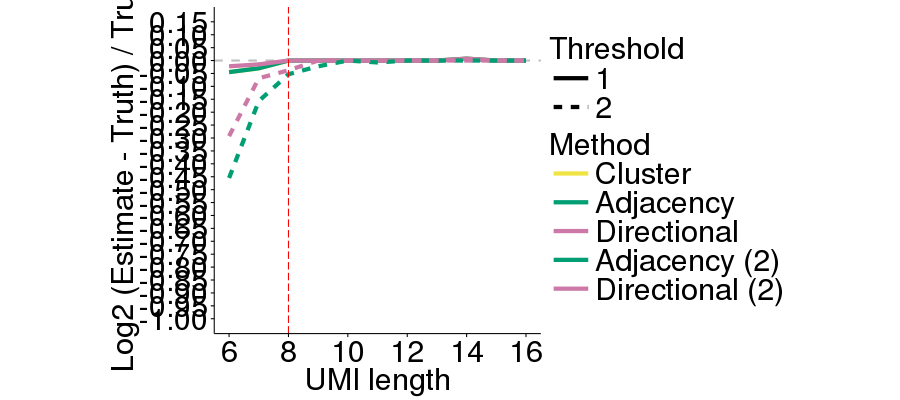

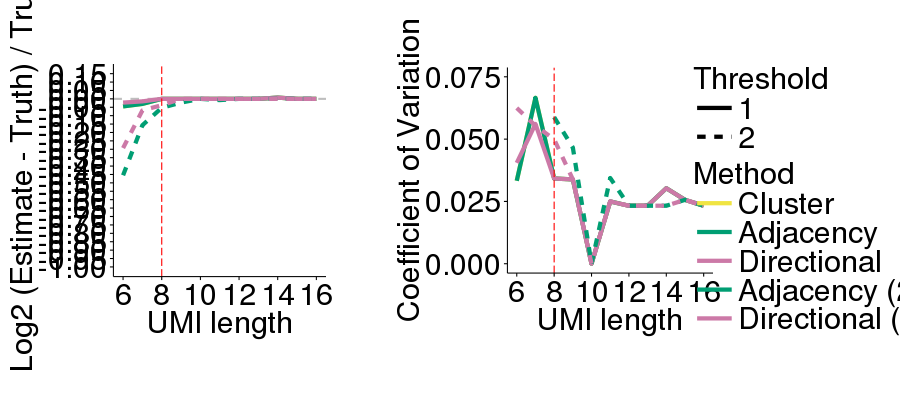

In [35]:
%%R -i df_UMI_length -w 900 -h 400 -u px
breaks = seq(6, 16, 2)
network_breaks = seq(20, 100, 20)

df_UMI_length = df_UMI_length[df_UMI_length$variable>5,]

plot_simulations(df_UMI_length, plotdir, difference=TRUE, umi_count=20,
                 variable="umi_length_xintercept", 
                 xlab="UMI length", xvert=8,
                 xint=FALSE, breaks=breaks, network_breaks=network_breaks,
                 difference_y_breaks=seq(-0.5,0.5,0.25),
                 y_breaks=seq(-1, 0.15, 0.05),
                 network_y_breaks=seq(0,100,20), complex_network_breaks=seq(0, 6.9, 1),
                 no_true_y_breaks=seq(0, 0.15, 0.05),
                 cv_y_breaks=seq(0, 0.075, 0.025),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE)

[1] "../figures.dir/simulation_number_of_umis_difference_deduped.svg"


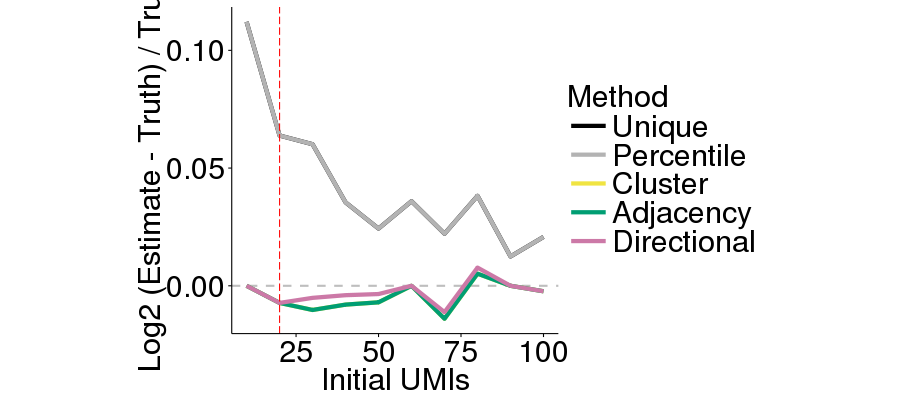

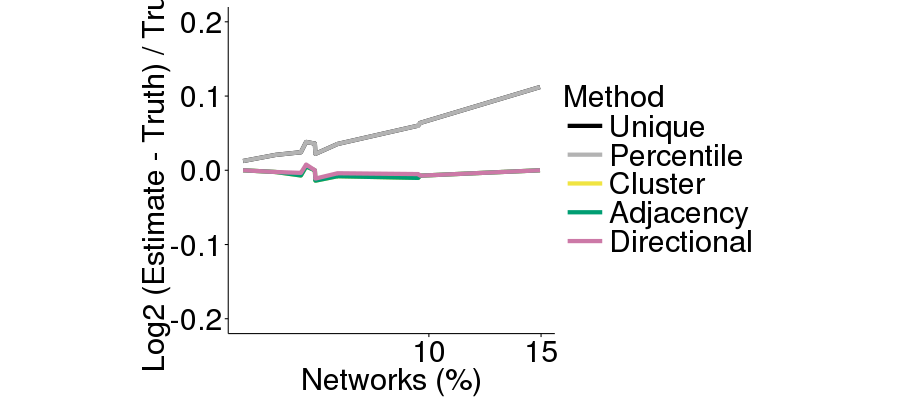

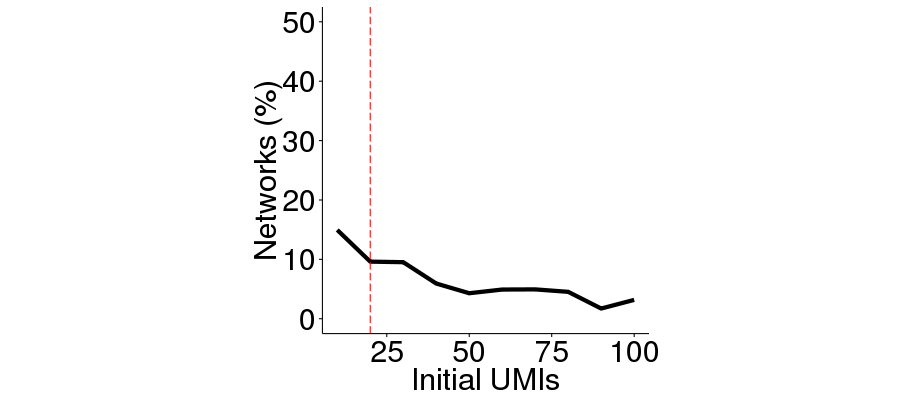

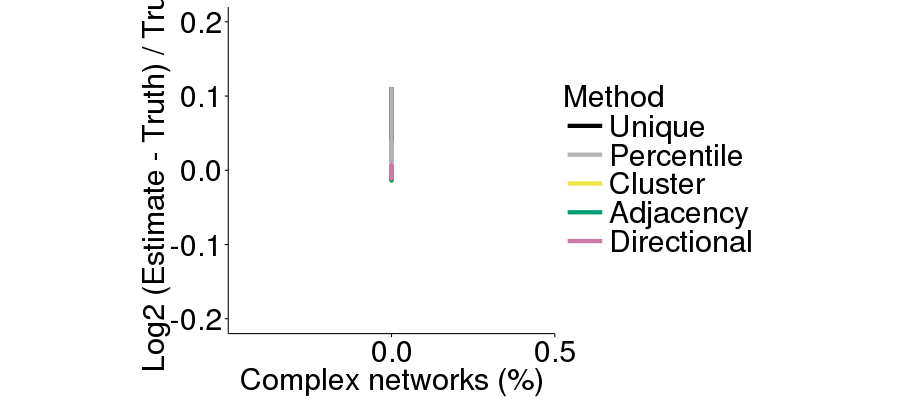

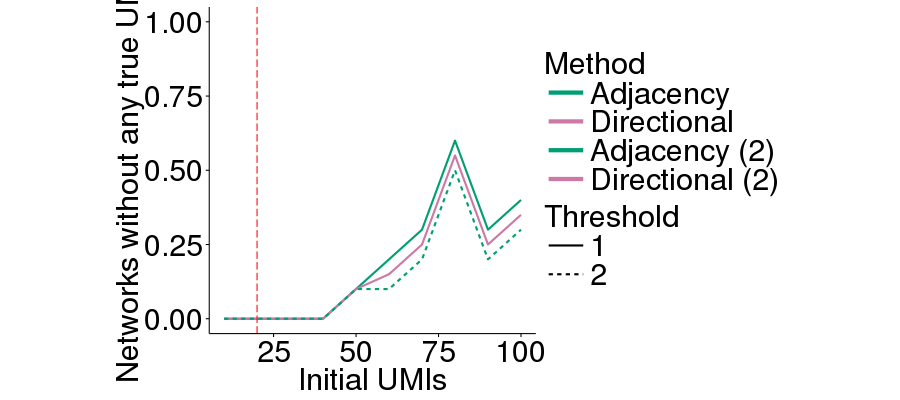

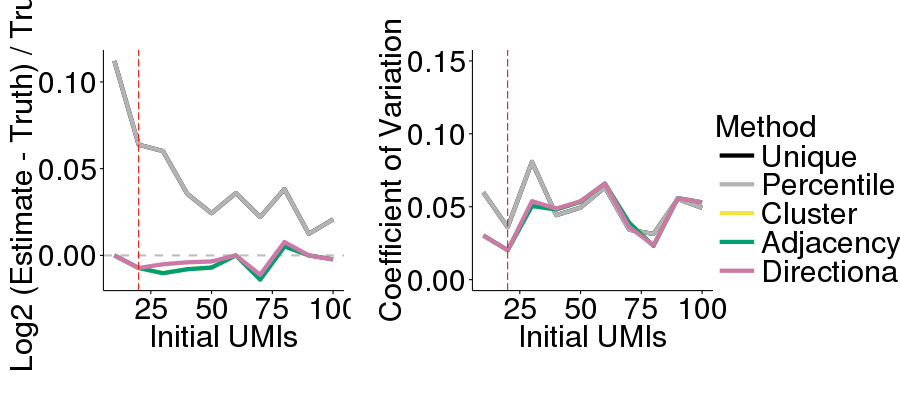

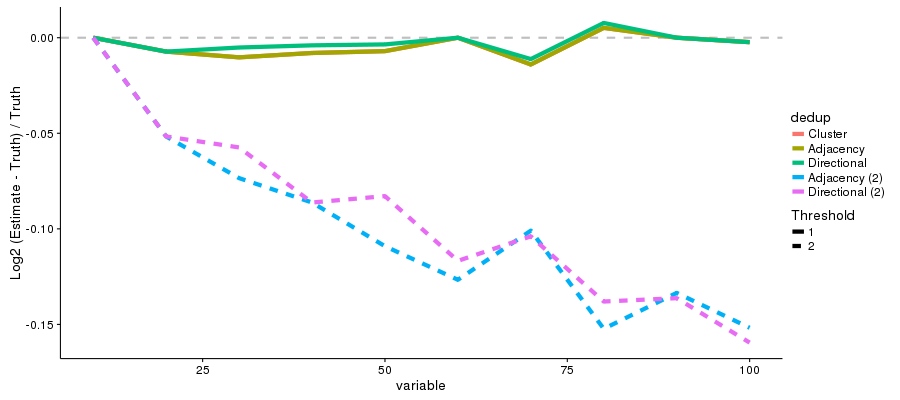

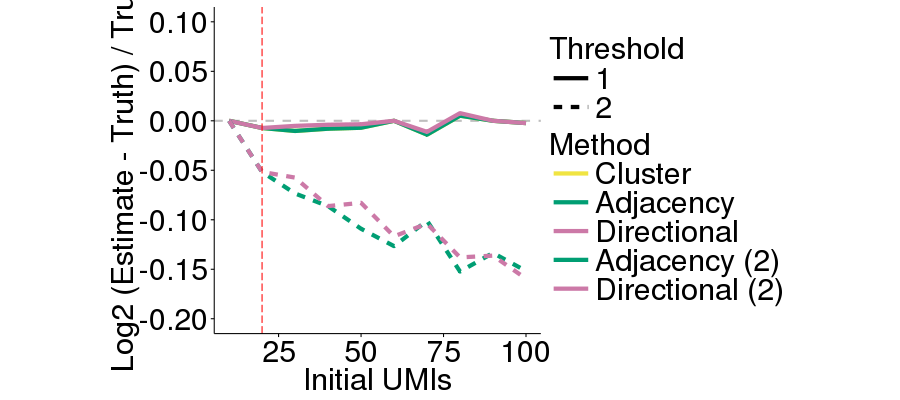

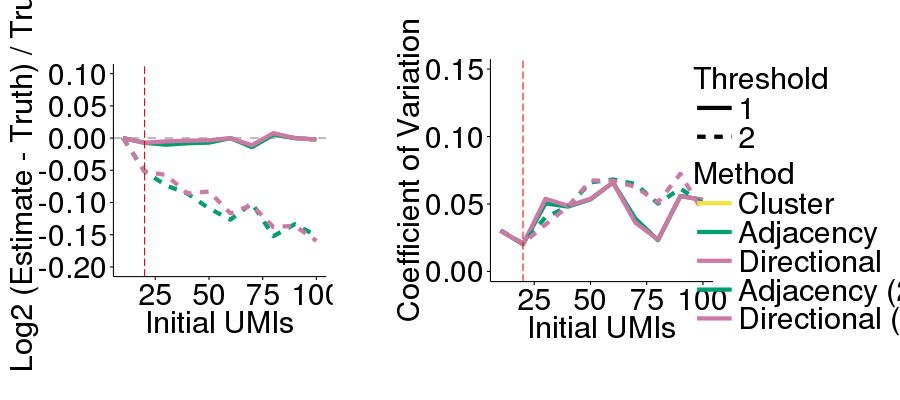

In [36]:
%%R -i df_Number_of_Molecules   -w 900 -h 400 -u px
breaks = seq(0, 100, 25)
network_breaks = seq(10, 50, 5)
plot_simulations(df_Number_of_Molecules, plotdir, difference=TRUE, umi_count=FALSE,
                 variable="number_of_umis", xlab="Initial UMIs",
                 xint=FALSE, breaks=breaks, network_breaks=network_breaks,
                 xvert=20, difference_y_breaks=seq(-0.2,0.2,0.1),
                 y_breaks=seq(-0.2, 0.1, 0.05),
                 network_y_breaks=seq(0,50,10), complex_network_breaks=seq(0,2,0.5),
                 no_true_y_breaks=seq(0, 1, 0.25),
                 cv_y_breaks=seq(0, 0.15, 0.05),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE)



[1] "../figures.dir/simulation_pcr_cycles_xintercept_difference_deduped.svg"


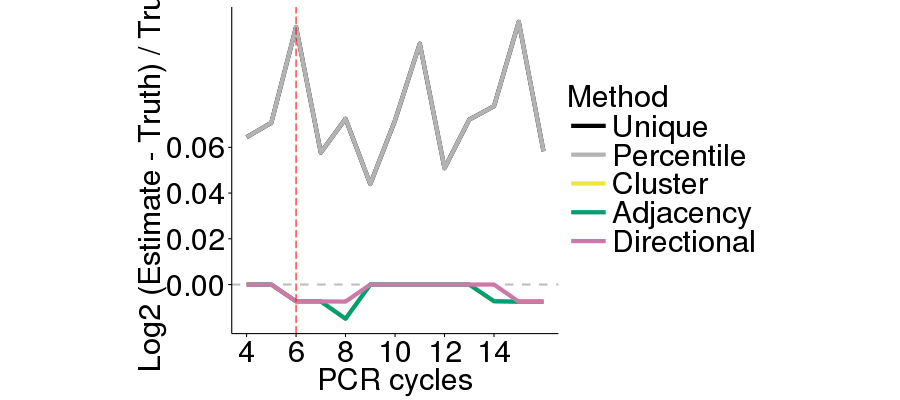

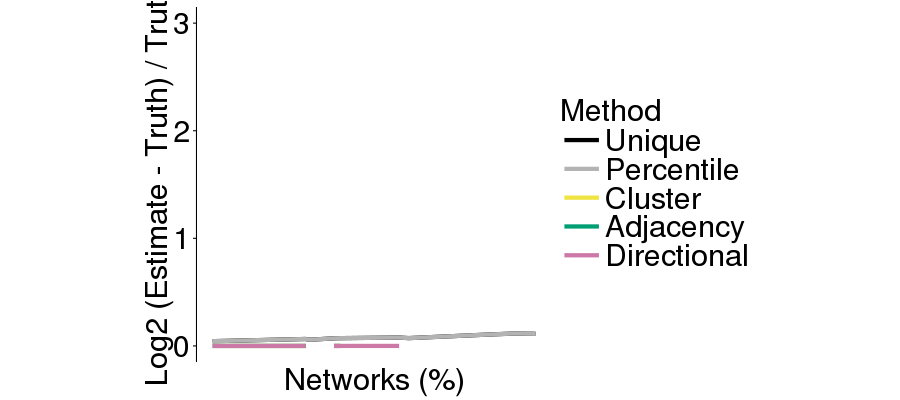

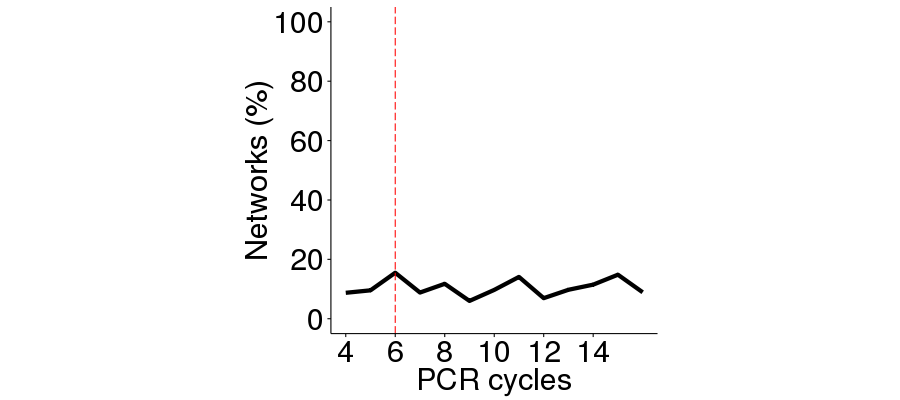

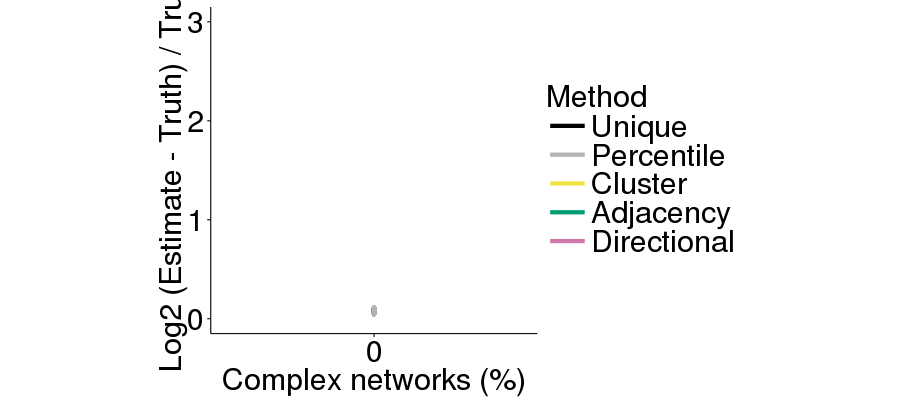

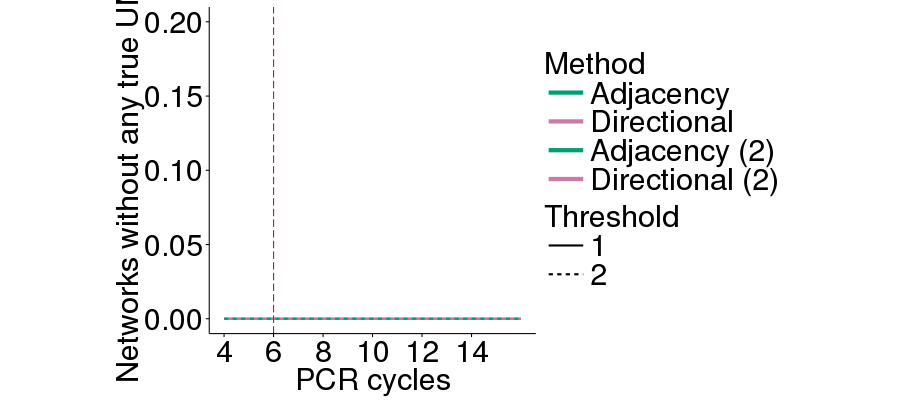

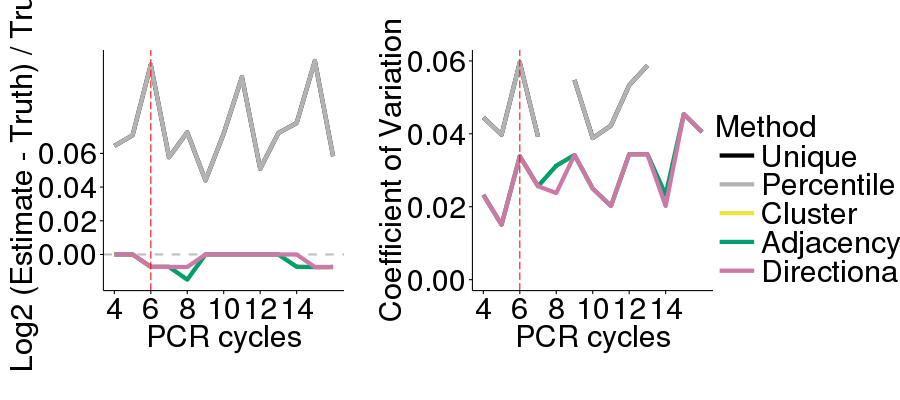

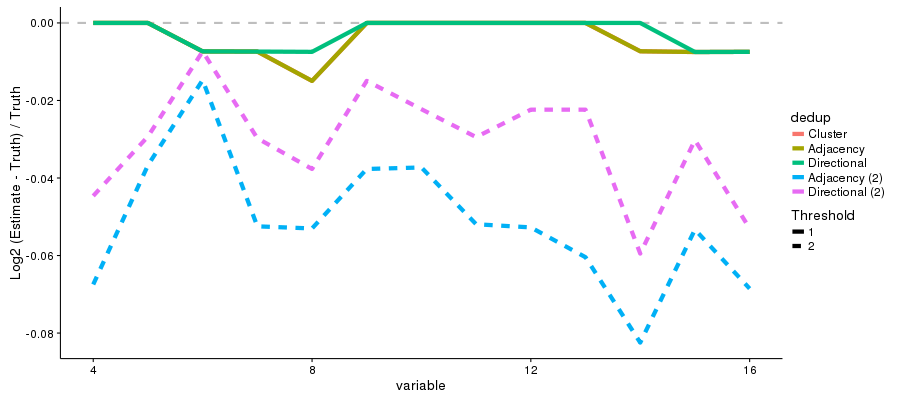

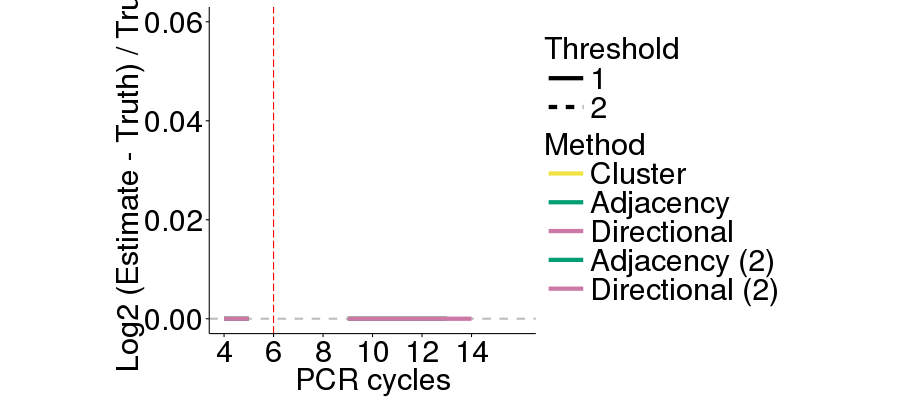

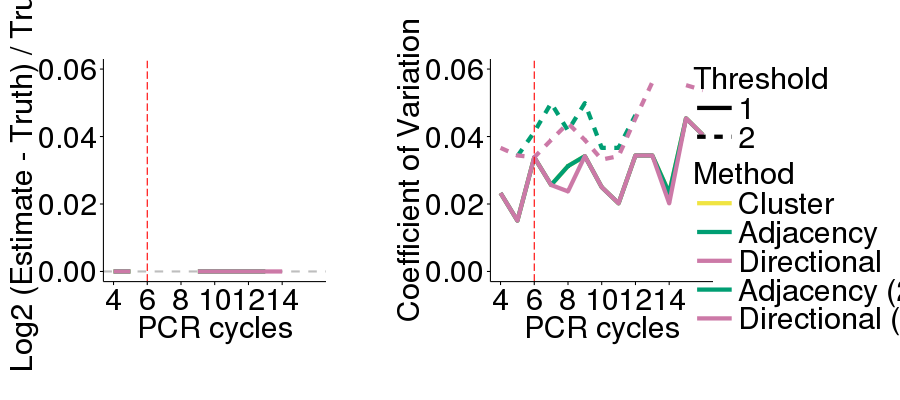

In [37]:
%%R -i df_PCR_cycles -w 900 -h 400 -u px
breaks = seq(0, 15, 2)
network_breaks = seq(0,100,20)

plot_simulations(df_PCR_cycles, plotdir, umi_count=20, difference=TRUE,
                 variable="pcr_cycles_xintercept", xint=FALSE, breaks=breaks,
                 xlab="PCR cycles", xvert=6,
                network_breaks=network_breaks,
                 difference_y_breaks=seq(0, 3, 1),
                 y_breaks=seq(0, 0.06, 0.02),
                 network_y_breaks=seq(0,100,20), complex_network_breaks=seq(0, 5, 1),
                 no_true_y_breaks=seq(0, 0.2, 0.05),
                 cv_y_breaks=seq(0, 0.06, 0.02),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE)

[1] "../figures.dir/simulation_seq_error_rate_xintercept_difference_deduped.svg"


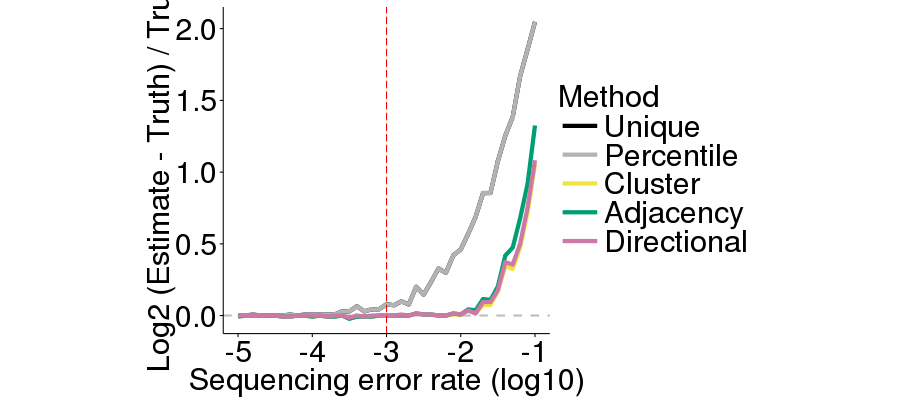

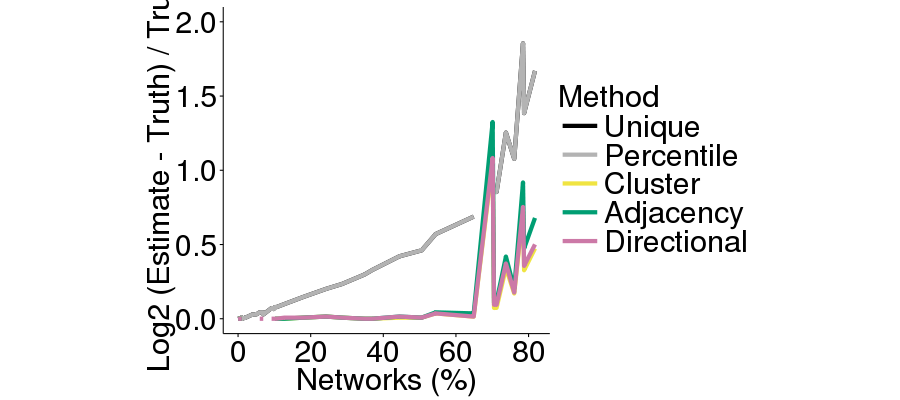

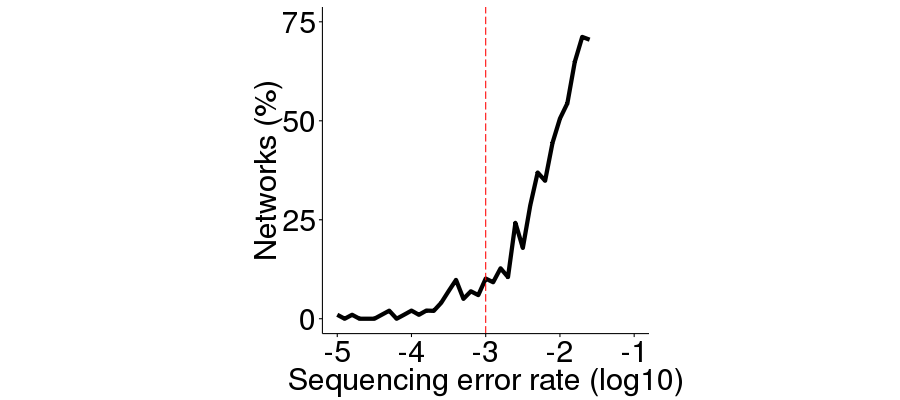

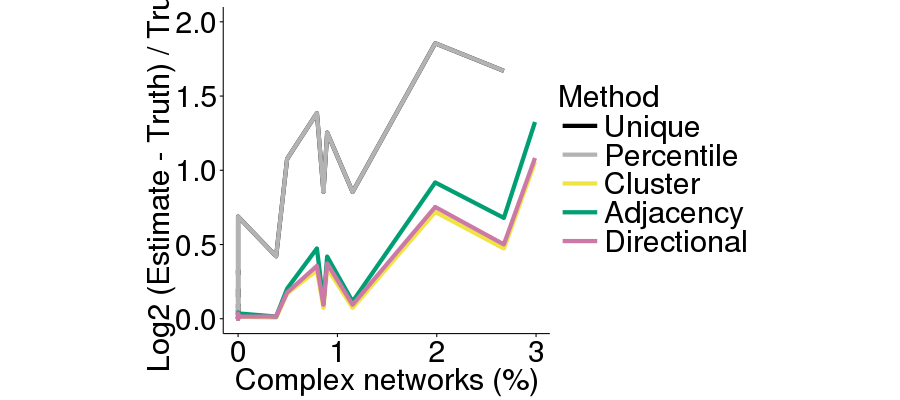

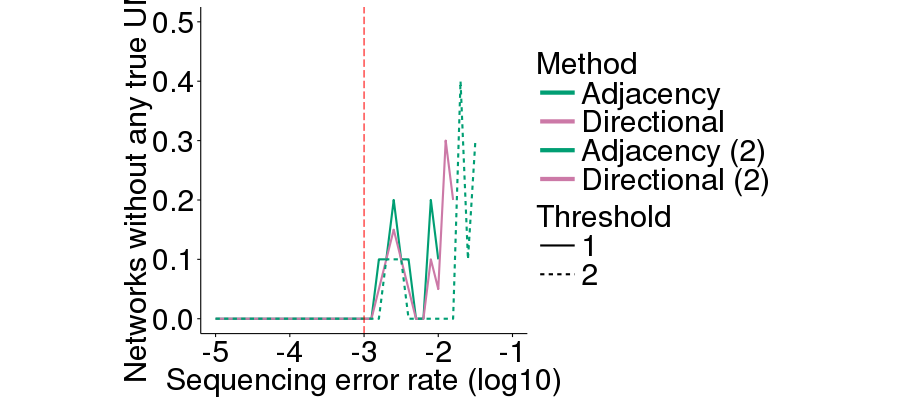

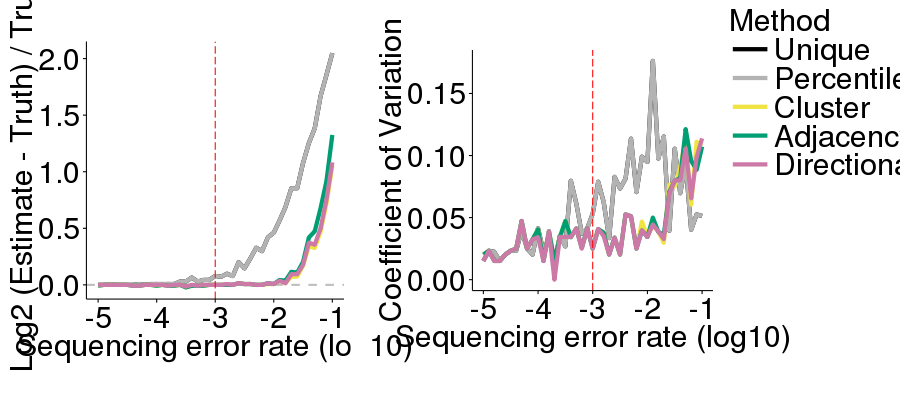

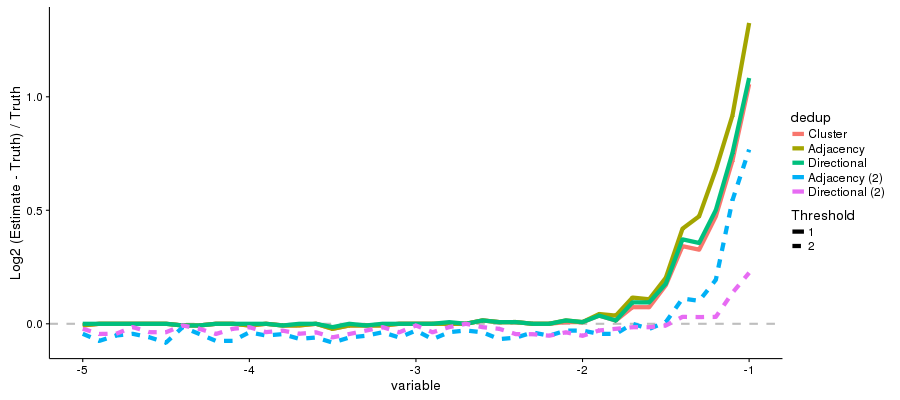

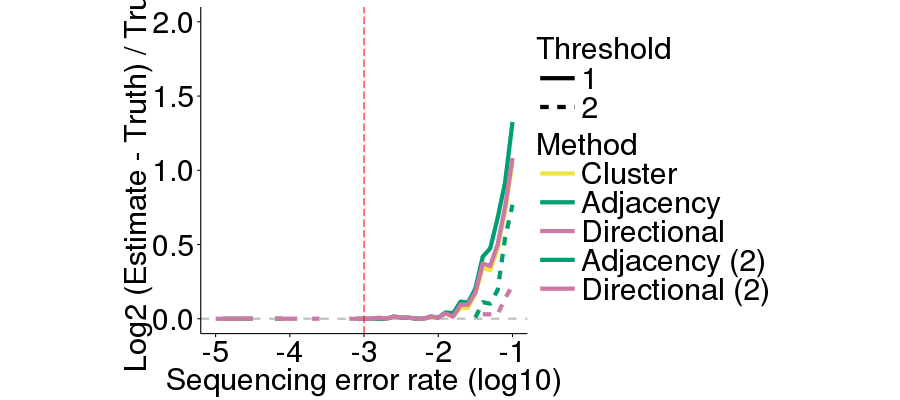

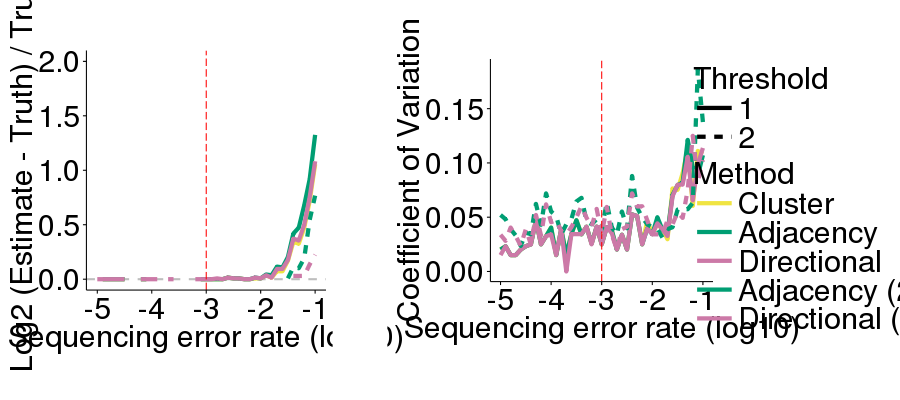

In [38]:
%%R -i df_Sequencing_error_rate -w 900 -h 400 -u px
breaks = seq(-5, -1, 1)
network_breaks = seq(0,100,20)

plot_simulations(df_Sequencing_error_rate, plotdir, difference=TRUE,
                 umi_count=20,
                 variable="seq_error_rate_xintercept",
                 xlab="Sequencing error rate (log10)",
                 xint=TRUE, xvert=-3,
                 network_breaks=network_breaks,
                 difference_y_breaks=seq(0,2,0.5),
                 y_breaks=seq(0,2,0.5),
                 network_y_breaks=seq(0,75,25),
                 complex_network_breaks=seq(0, 5, 1),
                 no_true_y_breaks=seq(0, 0.5, 0.1),
                 #cv_y_breaks=seq(0, 0.15, 0.05),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE)

[1] "../figures.dir/simulation_dna_pol_error_rate_xintercept_difference_deduped.svg"


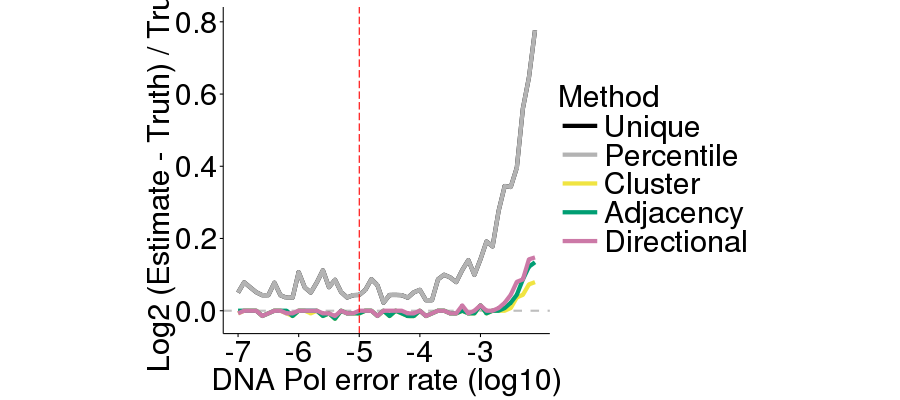

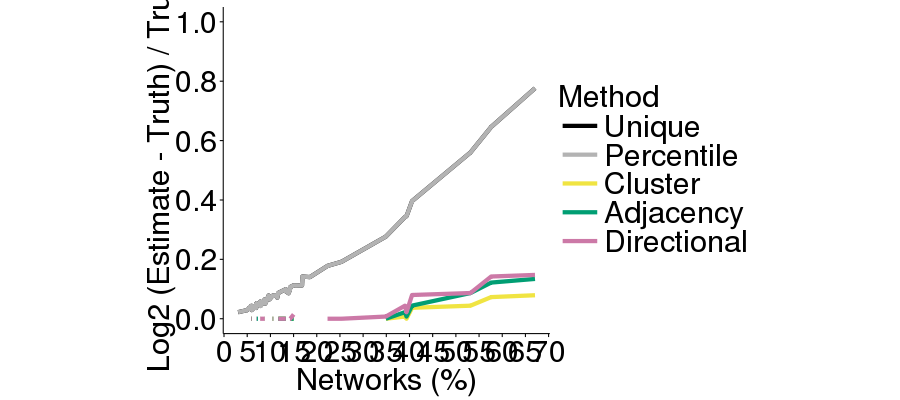

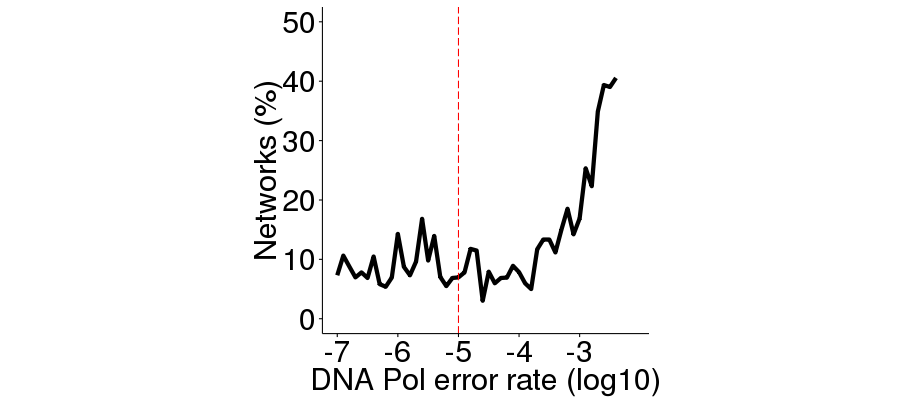

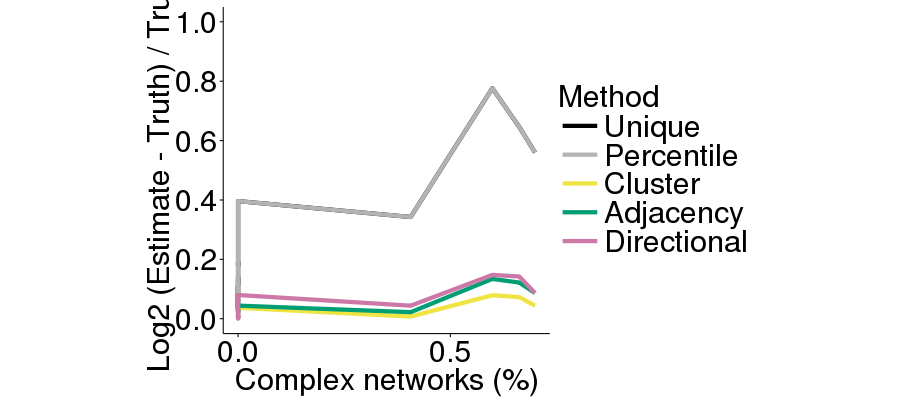

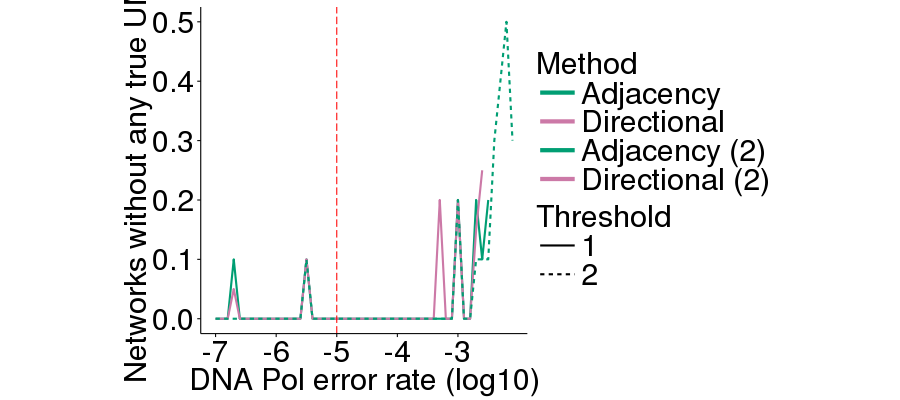

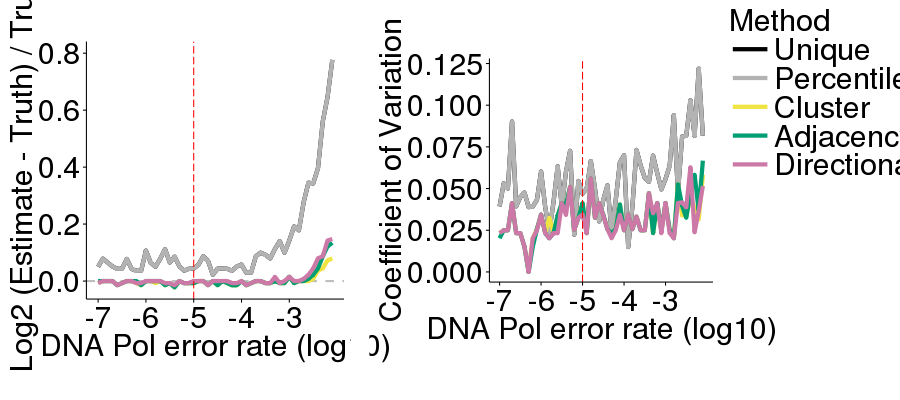

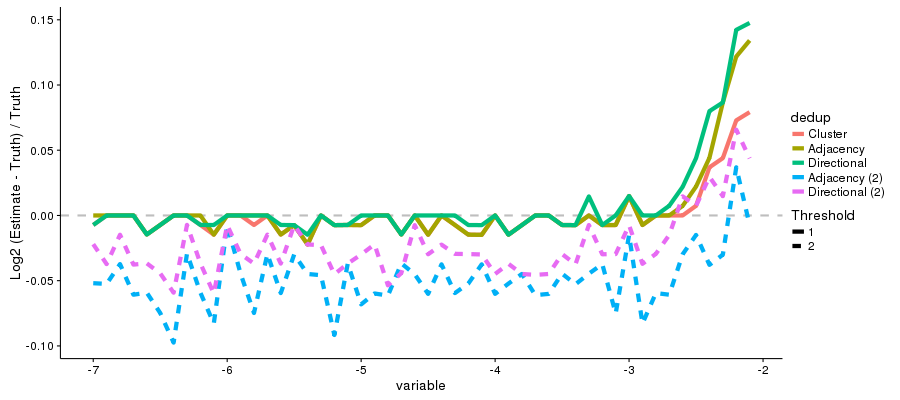

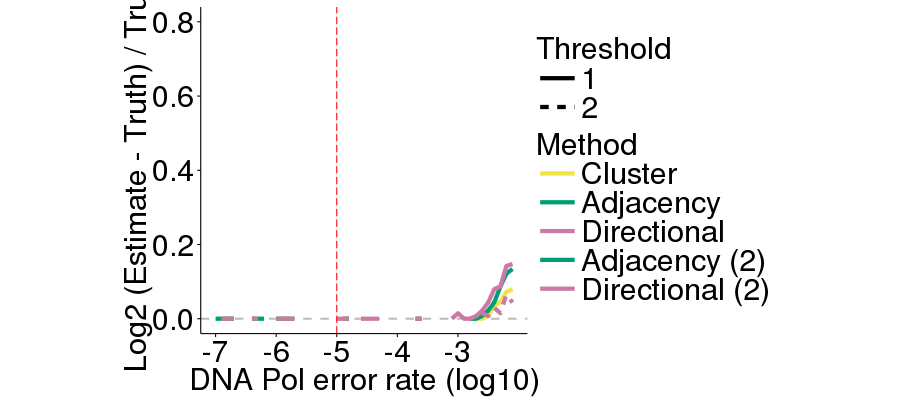

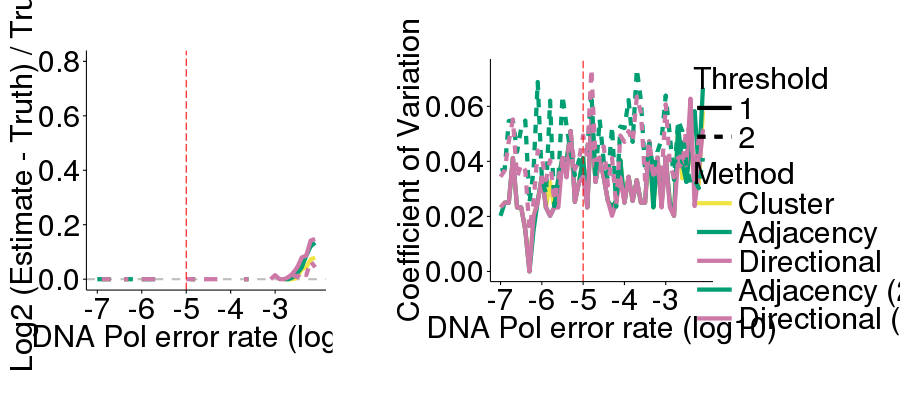

In [39]:
%%R -i df_DNA_pol_error_rate -w 900 -h 400 -u px
breaks = seq(-7,-2, 1)
network_breaks = seq(0,100,5)
plot_simulations(df_DNA_pol_error_rate, plotdir, difference=TRUE, umi_count=20,
                 variable="dna_pol_error_rate_xintercept",
                 xlab="DNA Pol error rate (log10)",
                 xint=TRUE, xvert=-5,
                network_breaks=network_breaks,
                 difference_y_breaks=seq(0,1,0.2), y_breaks=seq(0,0.8,0.2),
                 network_y_breaks=seq(0,50,10), complex_network_breaks=seq(0, 10, 0.5),
                 no_true_y_breaks=seq(0, 0.5, 0.1),
                 #cv_y_breaks=seq(0, 0.12, 0.03),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE,
                breaks=breaks)

[1] "../figures.dir/simulation_eff_min_xintercept_difference_deduped.svg"


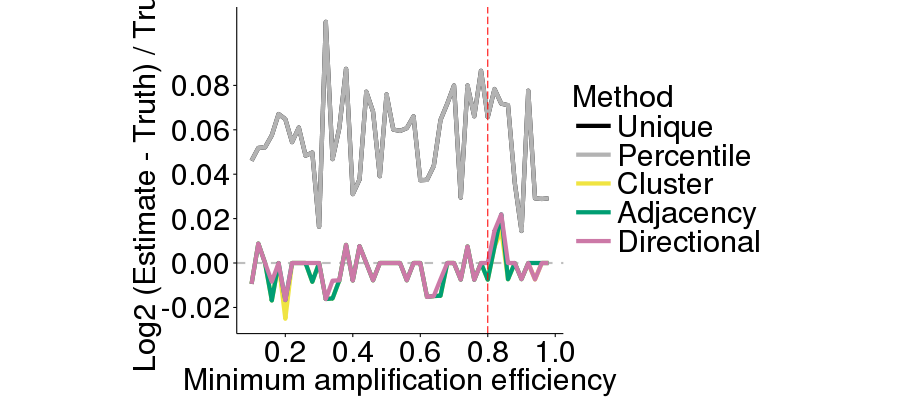

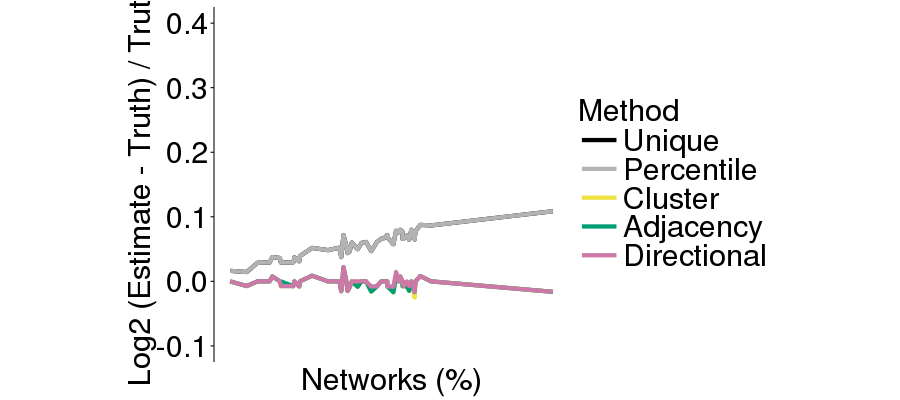

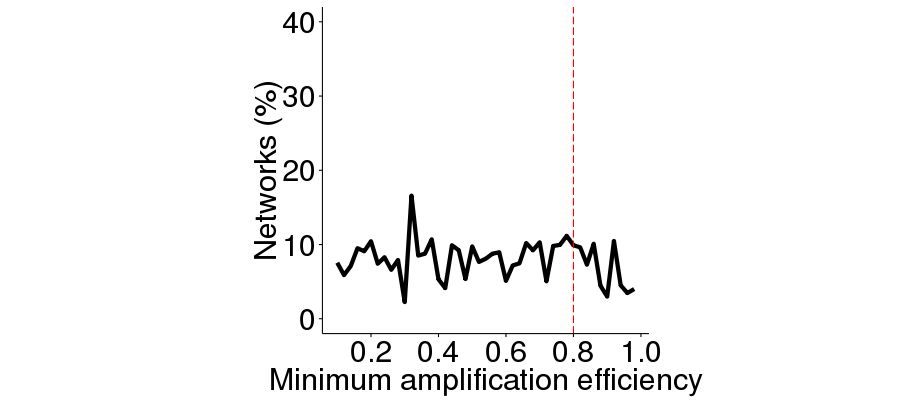

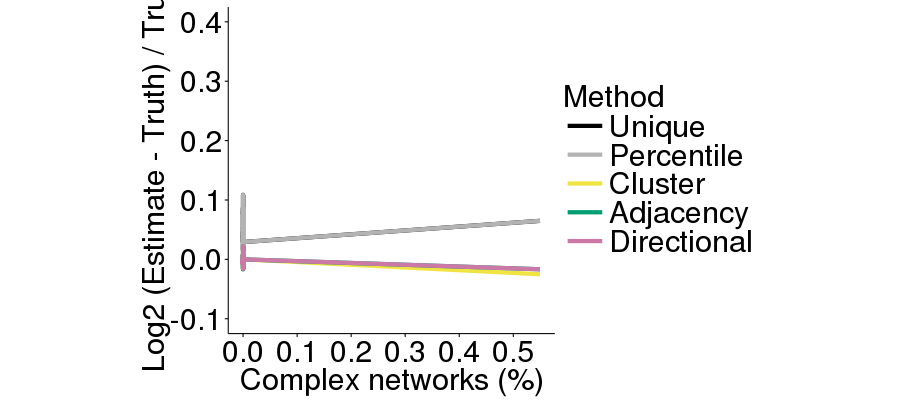

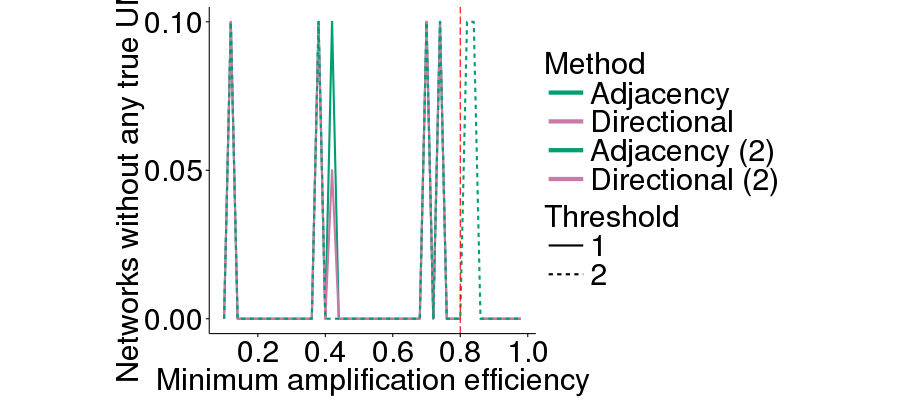

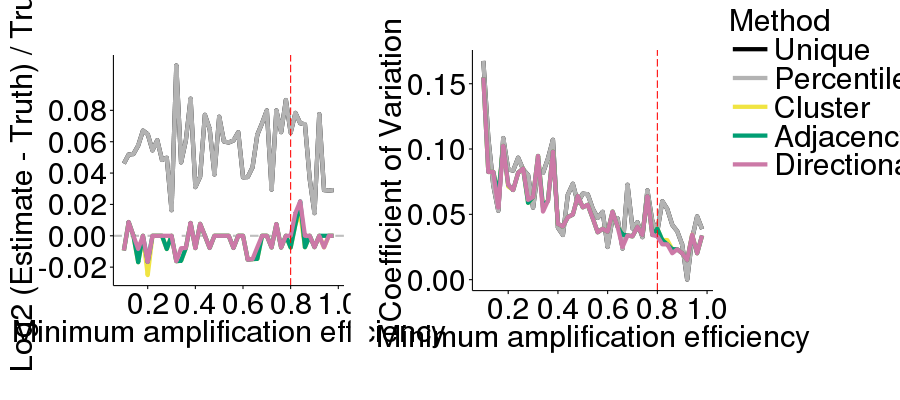

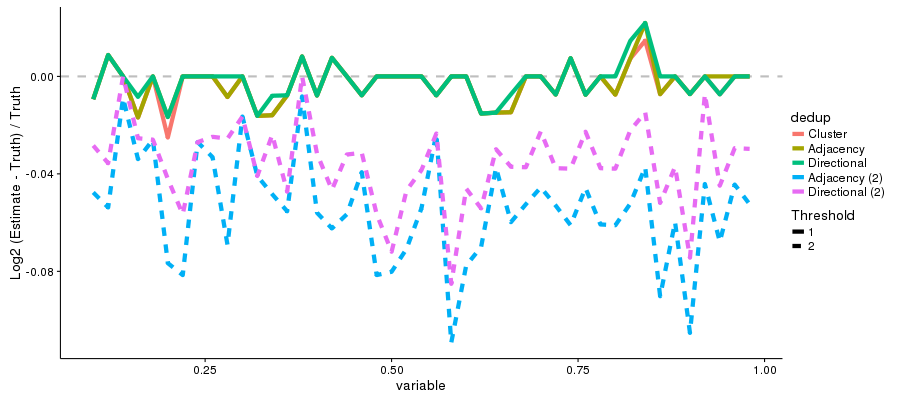

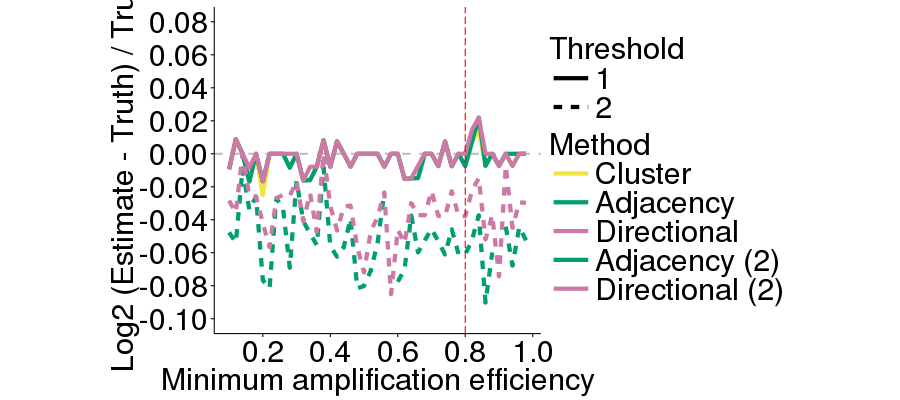

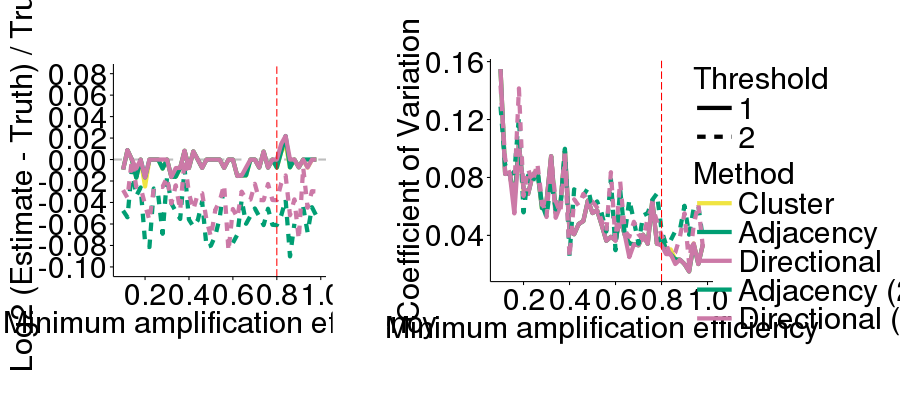

In [40]:
%%R -i df_Minimum_amplification_efficiency -w 900 -h 400 -u px
breaks = seq(0.2, 1, 0.2)
network_breaks = seq(0, 100, 20)
plot_simulations(df_Minimum_amplification_efficiency, plotdir, difference=TRUE,
                 umi_count=20,
                 variable="eff_min_xintercept",
                 xlab="Minimum amplification efficiency",
                 xint=FALSE, xvert=0.8, breaks=breaks,
                 network_breaks=network_breaks,
                 difference_y_breaks=seq(-0.1,0.4,0.1),
                 y_breaks=seq(-0.1,0.08,0.02),
                 network_y_breaks=seq(0, 40, 10),
                 complex_network_breaks=seq(0, 1, 0.1),
                 no_true_y_breaks=seq(0, 0.1, 0.05),
                 #cv_y_breaks=seq(0, 0.1, 0.05),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_no_true_networks=TRUE)

The following re-definition of the simulator class is used to generate conditions where there is an observable difference between unique and percentile. Note the increase in the sample depth and pcr cycles and lower number of initial UMIs to ensure high read depth per umi.

In [41]:
class simulatorWithVariable2(simulatorWithVariable):
        
    def __init__(self,
                 iterations=1000,
                 umi_length=6,
                 pcr_cycles=12,
                 dna_pol_error_rate=-5,
                 seq_error_rate=-3,
                 eff_min=0.8,
                 eff_max=1.0,
                 number_of_umis=5,
                 sample_depth=1000):
        
        self.iterations = iterations
        self.umi_length = umi_length
        self.pcr_cycles = pcr_cycles
        self.dna_pol_error_rate = dna_pol_error_rate
        self.seq_error_rate = seq_error_rate
        self.eff_min = eff_min
        self.eff_max = eff_max
        self.number_of_umis = number_of_umis
        self.sample_depth = sample_depth
        self.variable = None
    
    


In [43]:
iterations = 10
sim = simulatorWithVariable2(iterations=iterations)
df_seq_error2 = sim.iterator("seq_error_rate", -5, -1.9, 0.1)
df_seq_error2.to_csv(os.path.join(wd, "simulation_seq_error_high_sampling.tsv"), sep="\t", index=False)

2016-11-08 11:14:17 3 % complete: seq_error_rate=-5
2016-11-08 11:14:17 6 % complete: seq_error_rate=-4
2016-11-08 11:14:18 9 % complete: seq_error_rate=-4
2016-11-08 11:14:18 12 % complete: seq_error_rate=-4
2016-11-08 11:14:18 16 % complete: seq_error_rate=-4
2016-11-08 11:14:19 19 % complete: seq_error_rate=-4
2016-11-08 11:14:19 22 % complete: seq_error_rate=-4
2016-11-08 11:14:20 25 % complete: seq_error_rate=-4
2016-11-08 11:14:20 29 % complete: seq_error_rate=-4
2016-11-08 11:14:21 32 % complete: seq_error_rate=-4
2016-11-08 11:14:21 35 % complete: seq_error_rate=-4
2016-11-08 11:14:22 38 % complete: seq_error_rate=-3
2016-11-08 11:14:22 41 % complete: seq_error_rate=-3
2016-11-08 11:14:23 45 % complete: seq_error_rate=-3
2016-11-08 11:14:23 48 % complete: seq_error_rate=-3
2016-11-08 11:14:23 51 % complete: seq_error_rate=-3
2016-11-08 11:14:24 54 % complete: seq_error_rate=-3
2016-11-08 11:14:24 58 % complete: seq_error_rate=-3
2016-11-08 11:14:25 61 % complete: seq_error_rate

In [44]:
df_seq_error2 = pd.read_table(os.path.join(wd, "simulation_seq_error_high_sampling.tsv"), sep="\t")

[1] "../figures.dir/simulation_seq_error_high_sampling_xintercept_difference_deduped.svg"


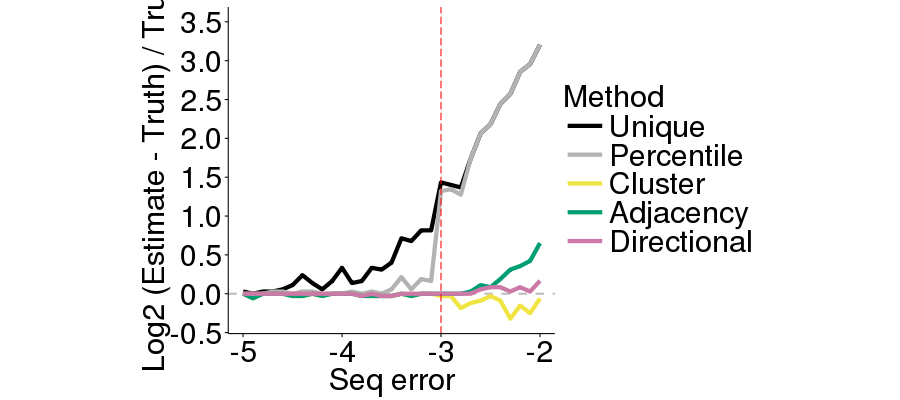

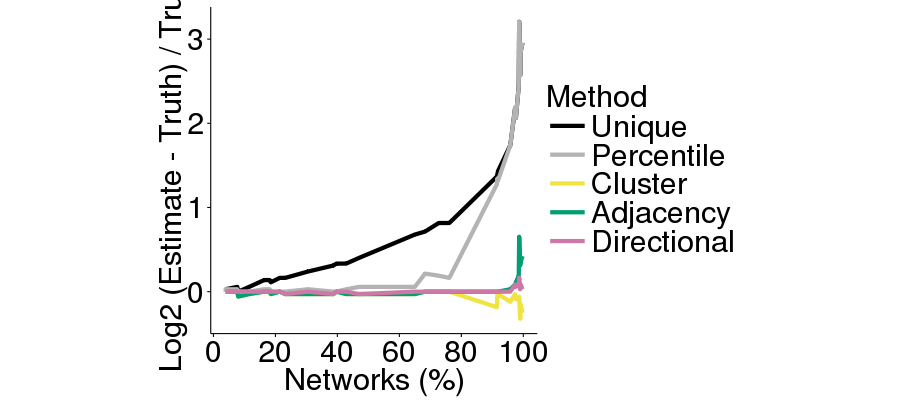

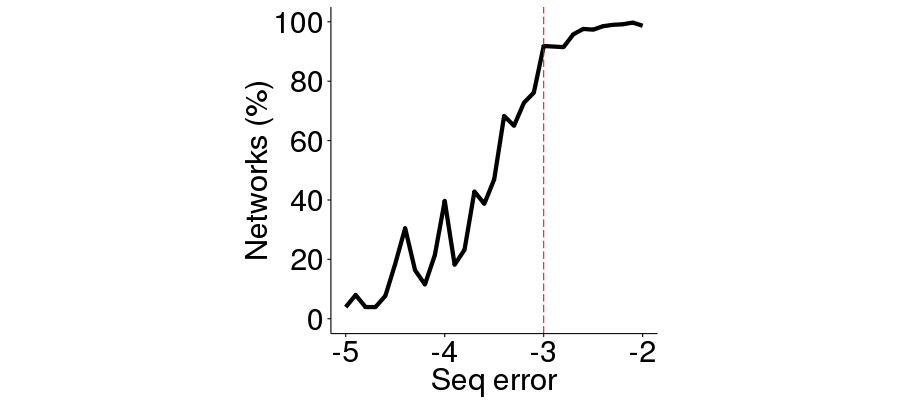

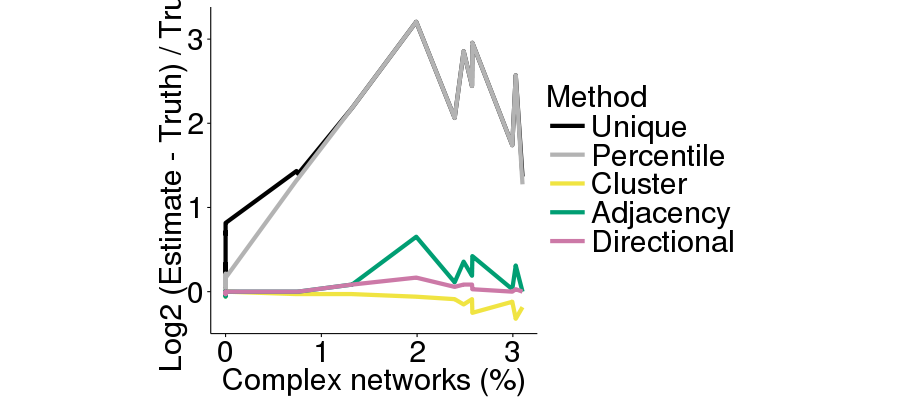

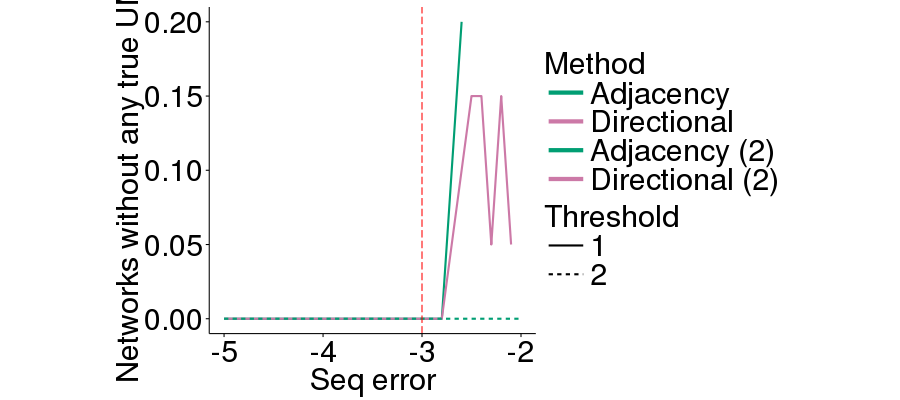

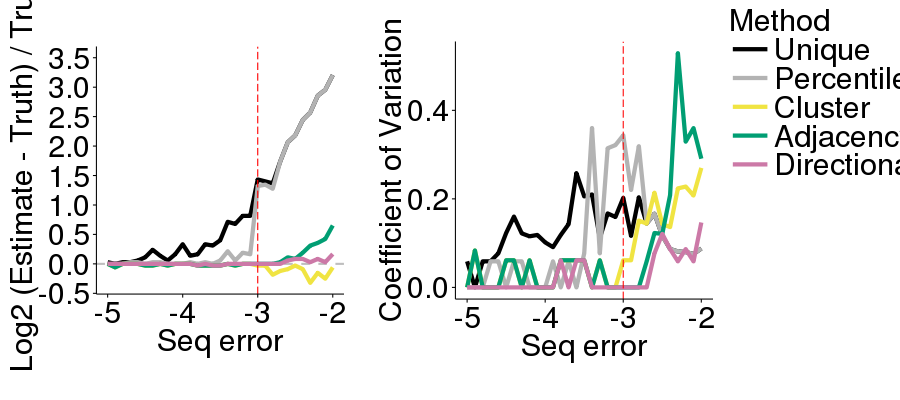

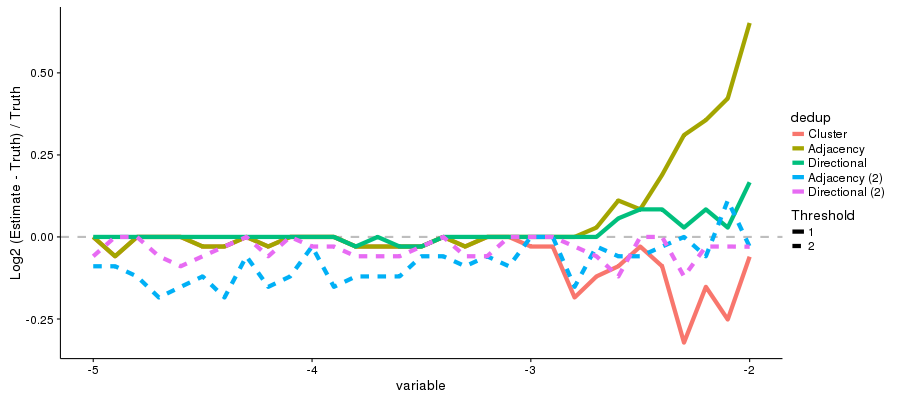

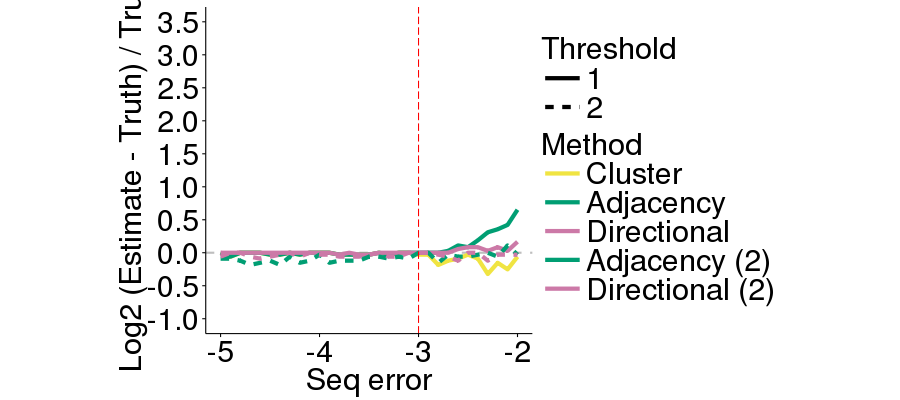

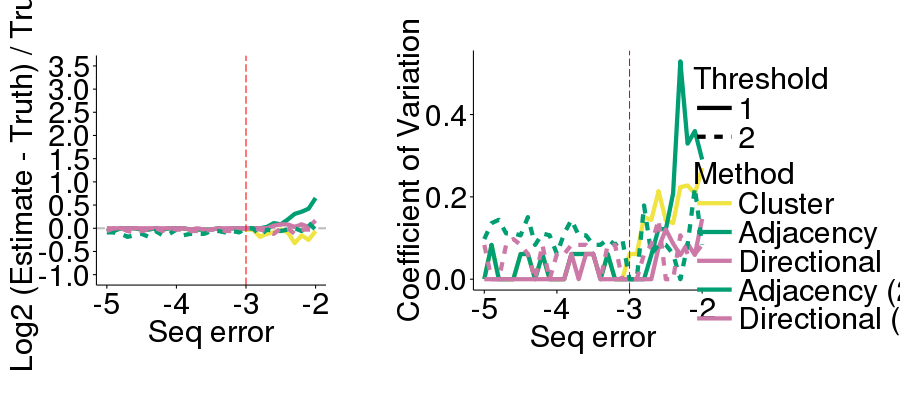

In [45]:
%%R -i df_seq_error2 -w 900 -h 400 -u px
breaks = seq(-5, -1.9, 1)
network_breaks = seq(0,100,20)

plot_simulations(df_seq_error2, plotdir, umi_count=2, difference=TRUE,
                 variable="seq_error_xintercept", xint=FALSE, breaks=breaks,
                 xlab="Seq error", xvert=-3,
                network_breaks=network_breaks,
                 #difference_y_breaks=seq(-50, 250, 50),
                 y_breaks=seq(-1, 3.5, 0.5),
                 network_y_breaks=seq(0,100,20), complex_network_breaks=seq(0, 5, 1),
                 no_true_y_breaks=seq(0, 0.2, 0.05),
                 #cv_y_breaks=seq(0, 0.4, 0.1),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_variable_name = "seq_error_high_sampling_xintercept",
                 plot_no_true_networks=TRUE)

In [46]:
sim = simulatorWithVariable(iterations=1000,
                 umi_length=8,
                 pcr_cycles=6,
                 dna_pol_error_rate=-5,
                 seq_error_rate=-3,
                 eff_min=0.9,
                 eff_max=1.0,
                 number_of_umis=20,
                 sample_depth=500)
df_Number_of_Molecules = sim.iterator("number_of_umis", 10, 1001, 100)
df_Number_of_Molecules.to_csv(os.path.join(wd, "simulation_number_molecules_extreme.tsv"), sep="\t", index=False)

2016-11-08 11:14:41 10 % complete: number_of_umis=10
2016-11-08 11:14:41 20 % complete: number_of_umis=110
2016-11-08 11:14:44 30 % complete: number_of_umis=210
2016-11-08 11:14:48 40 % complete: number_of_umis=310
2016-11-08 11:14:53 50 % complete: number_of_umis=410
2016-11-08 11:14:59 60 % complete: number_of_umis=510
2016-11-08 11:15:06 70 % complete: number_of_umis=610
2016-11-08 11:15:13 80 % complete: number_of_umis=710
2016-11-08 11:15:21 90 % complete: number_of_umis=810
2016-11-08 11:15:30 100 % complete: number_of_umis=910


[1] "../figures.dir/simulation_number_molecules_xintercept_extreme_difference_deduped.svg"


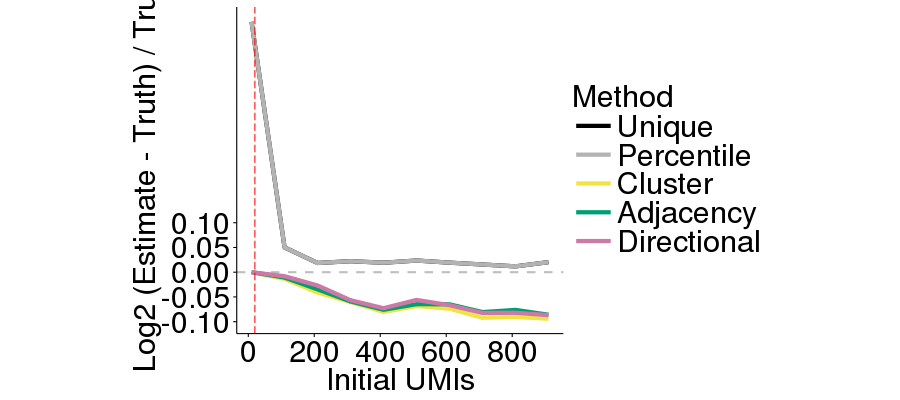

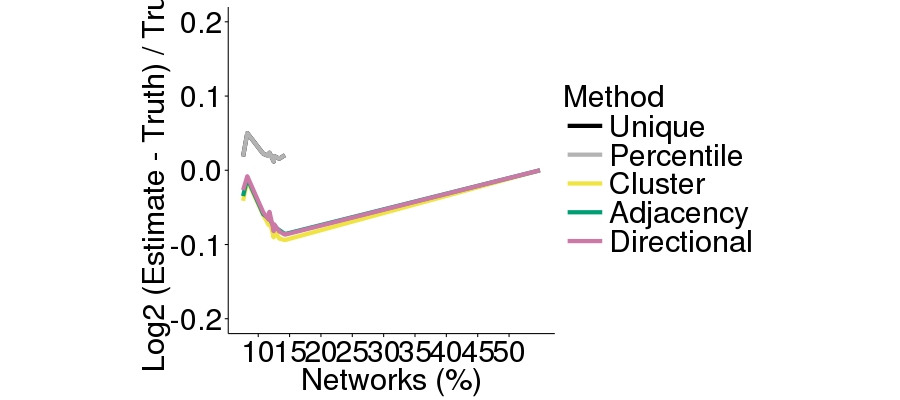

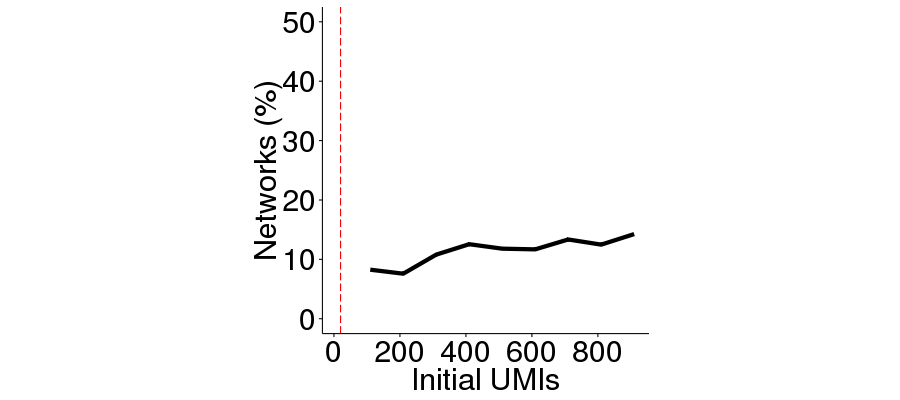

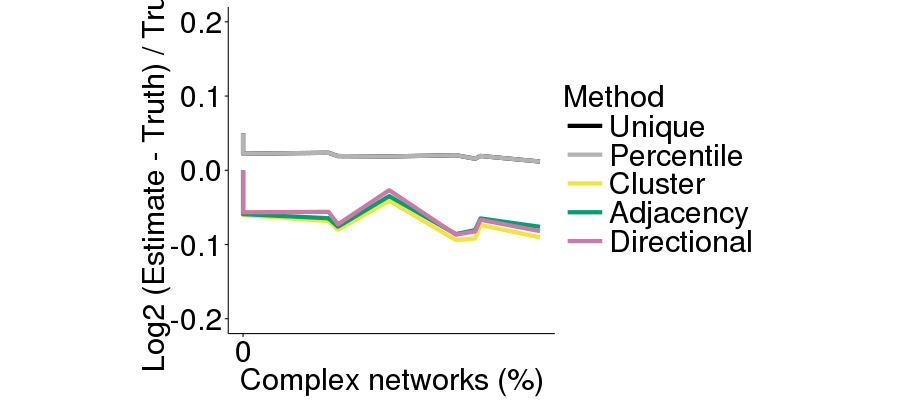

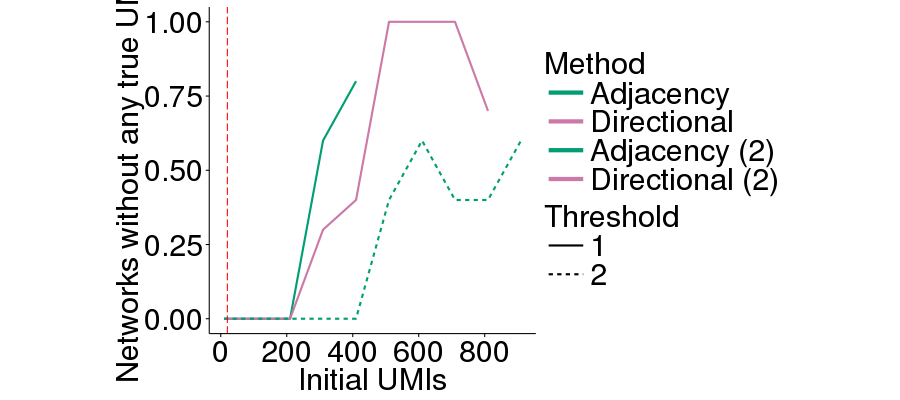

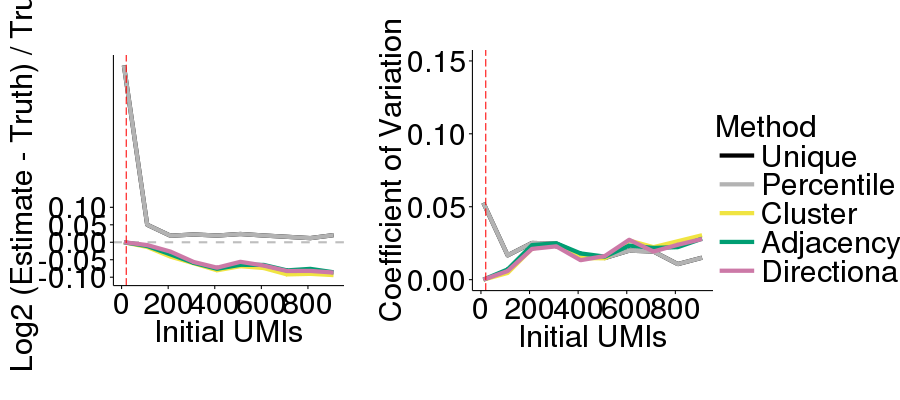

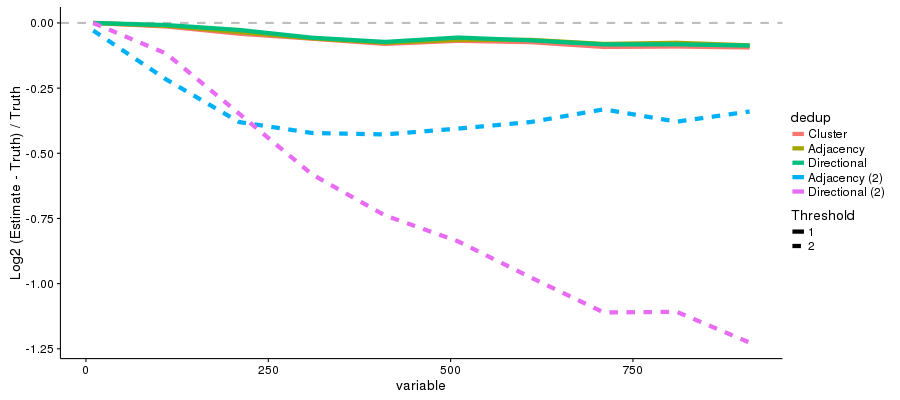

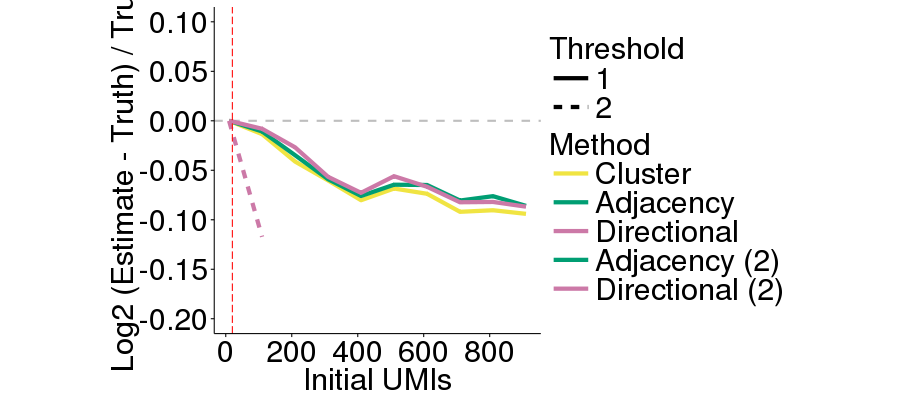

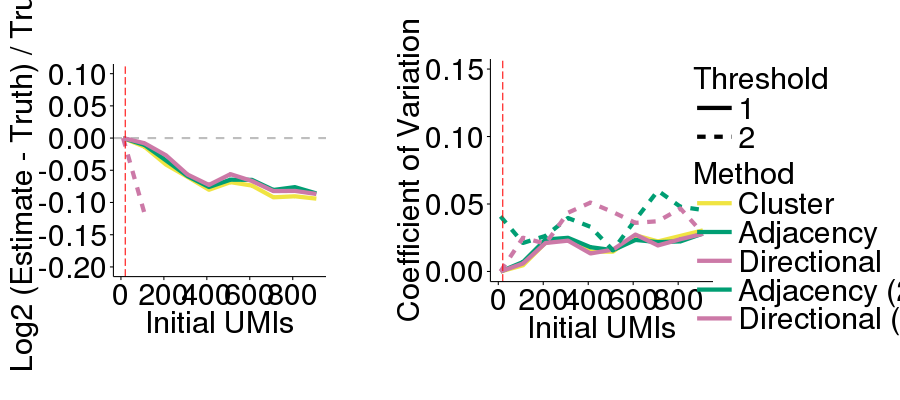

In [47]:
%%R -i df_Number_of_Molecules   -w 900 -h 400 -u px
breaks = seq(0, 1000, 200)
network_breaks = seq(10, 50, 5)
plot_simulations(df_Number_of_Molecules, plotdir, difference=TRUE, umi_count=FALSE,
                 variable="number_of_umis", xlab="Initial UMIs",
                 xint=FALSE, breaks=breaks, network_breaks=network_breaks,
                 xvert=20, difference_y_breaks=seq(-0.2,0.2,0.1),
                 y_breaks=seq(-0.2, 0.1, 0.05),
                 network_y_breaks=seq(0,50,10), complex_network_breaks=seq(0,2,0.5),
                 no_true_y_breaks=seq(0, 1, 0.25),
                 cv_y_breaks=seq(0, 0.15, 0.05),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_variable_name = "number_molecules_xintercept_extreme",
                 plot_no_true_networks=TRUE)



In [48]:
sim = simulatorWithVariable(iterations=1000,
                 umi_length=6,
                 pcr_cycles=8,
                 dna_pol_error_rate=-5,
                 seq_error_rate=-3,
                 eff_min=0.9,
                 eff_max=1.0,
                 number_of_umis=20,
                 sample_depth=100)
df_sample_depth_extreme = sim.iterator("sample_depth", 100, 2001, 100)
df_sample_depth_extreme.to_csv(os.path.join(wd, "simulation_seq_depth_extreme.tsv"), sep="\t", index=False)


2016-11-08 11:15:39 5 % complete: sample_depth=100
2016-11-08 11:15:40 10 % complete: sample_depth=200
2016-11-08 11:15:40 15 % complete: sample_depth=300
2016-11-08 11:15:40 20 % complete: sample_depth=400
2016-11-08 11:15:40 25 % complete: sample_depth=500
2016-11-08 11:15:40 30 % complete: sample_depth=600
2016-11-08 11:15:41 35 % complete: sample_depth=700
2016-11-08 11:15:41 40 % complete: sample_depth=800
2016-11-08 11:15:41 45 % complete: sample_depth=900
2016-11-08 11:15:42 50 % complete: sample_depth=1000
2016-11-08 11:15:42 55 % complete: sample_depth=1100
2016-11-08 11:15:42 60 % complete: sample_depth=1200
2016-11-08 11:15:43 65 % complete: sample_depth=1300
2016-11-08 11:15:43 70 % complete: sample_depth=1400
2016-11-08 11:15:43 75 % complete: sample_depth=1500
2016-11-08 11:15:43 80 % complete: sample_depth=1600
2016-11-08 11:15:44 85 % complete: sample_depth=1700
2016-11-08 11:15:44 90 % complete: sample_depth=1800
2016-11-08 11:15:44 95 % complete: sample_depth=1900
201

[1] "../figures.dir/simulation_sample_depth_extreme_xintercept_difference_deduped.svg"


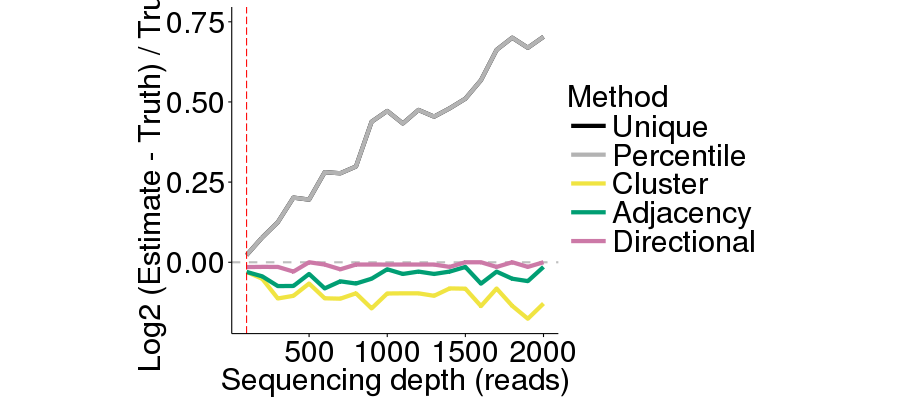

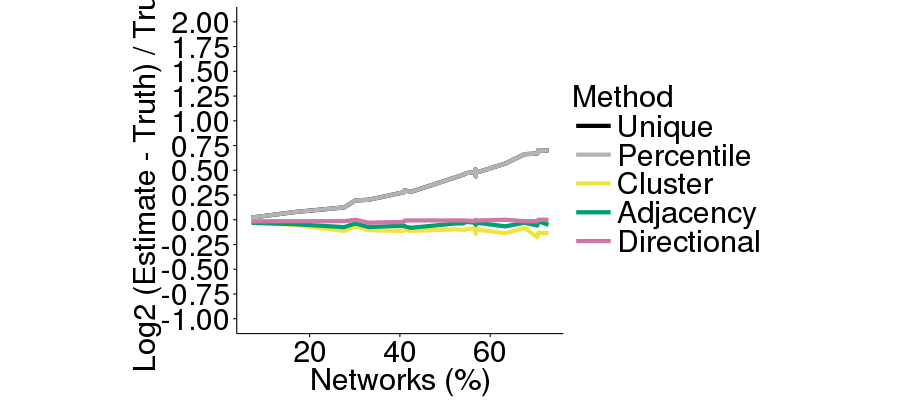

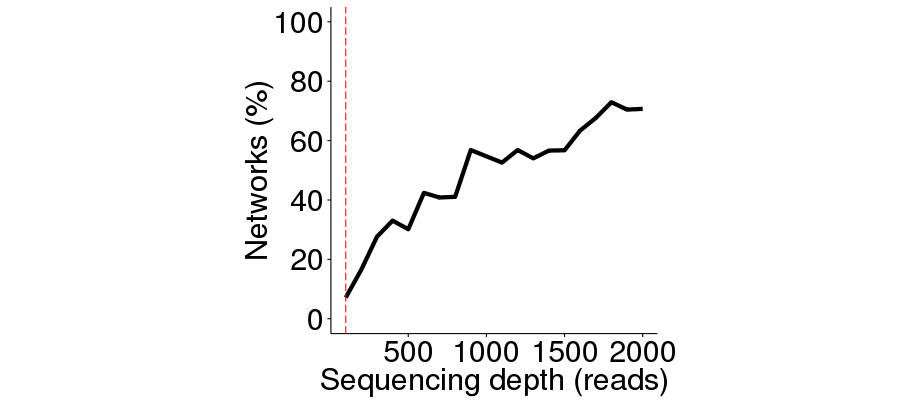

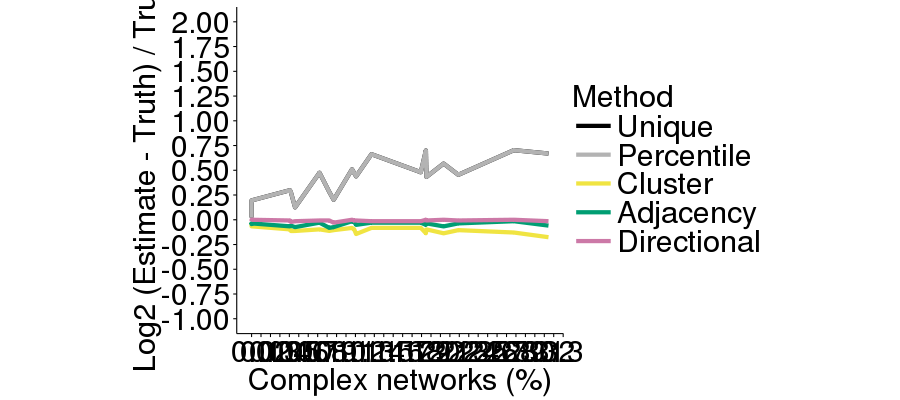

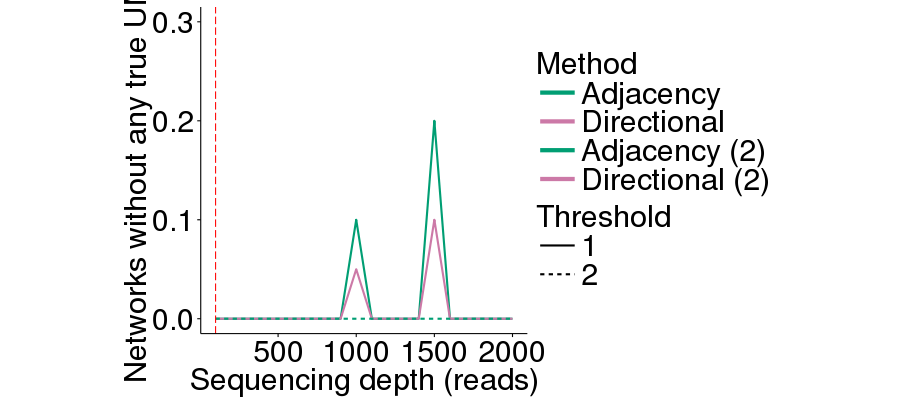

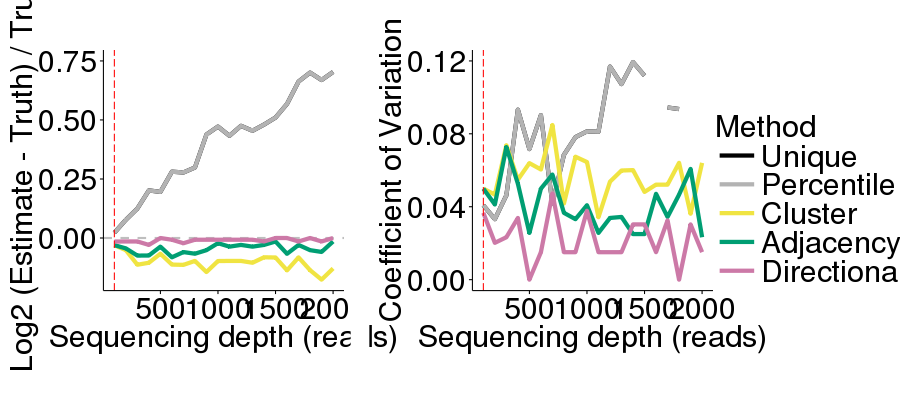

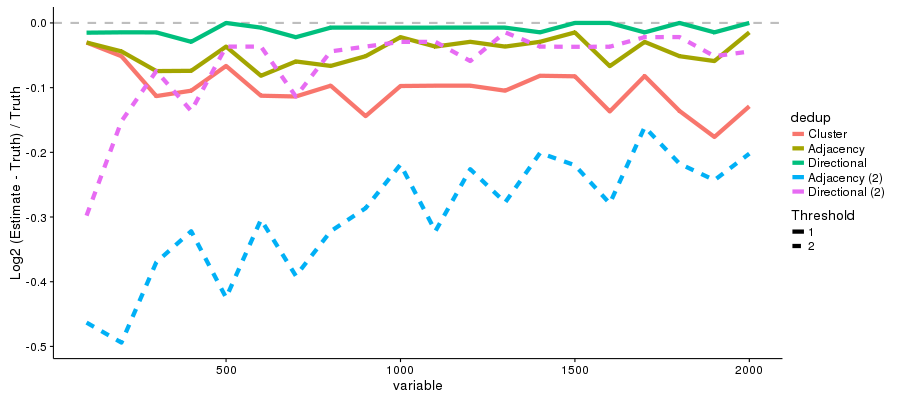

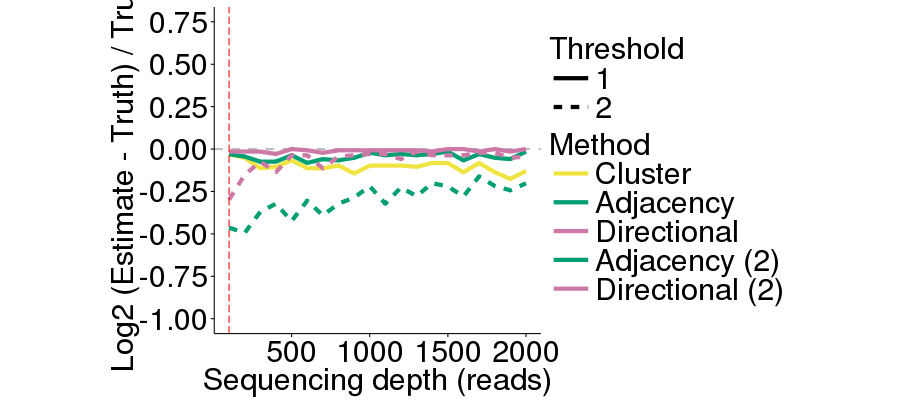

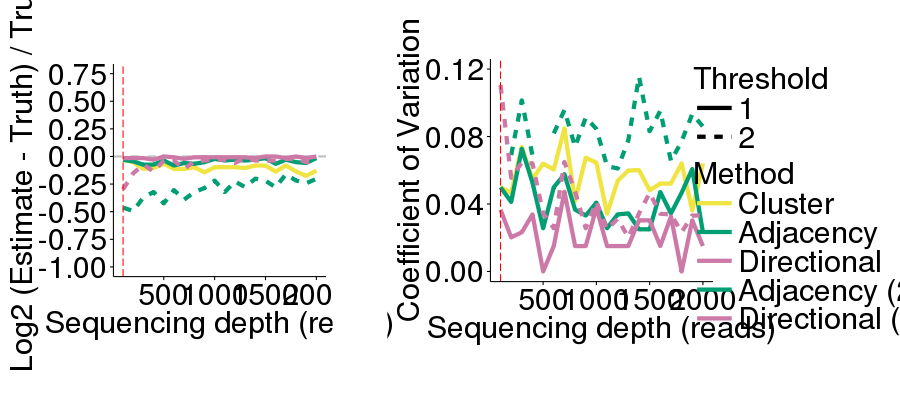

In [49]:
%%R -i df_sample_depth_extreme   -w 900 -h 400 -u px
breaks = seq(0, 2000, 500)
network_breaks = seq(0, 100, 20)
plot_simulations(df_sample_depth_extreme, plotdir, difference=TRUE, umi_count=20,
                 variable="sample_depth", xlab="Sequencing depth (reads)",
                 xint=FALSE, breaks=breaks, network_breaks=network_breaks,
                 xvert=100, difference_y_breaks=seq(-1,2,0.25),
                 y_breaks=seq(-1,0.75,0.25),
                 network_y_breaks=network_breaks,
                 no_true_y_breaks=seq(0, 0.3, 0.1),
                 cv_y_breaks=seq(0, 0.12, 0.04),
                 complex_network_breaks=seq(0,4,0.1),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_variable_name = "sample_depth_extreme_xintercept",
                 plot_no_true_networks=TRUE)

In [50]:
iterations = 10000
sim = simulatorWithVariable(iterations=iterations)
df_UMI_length_extreme = sim.iterator("umi_length", 10, 52, 2)
df_UMI_length_extreme.to_csv(os.path.join(wd, "simulation_umi_length_extreme.tsv"), sep="\t", index=False)

2016-11-08 11:15:54 4 % complete: umi_length=10
2016-11-08 11:15:54 9 % complete: umi_length=12
2016-11-08 11:15:54 14 % complete: umi_length=14
2016-11-08 11:15:55 19 % complete: umi_length=16
2016-11-08 11:15:55 23 % complete: umi_length=18
2016-11-08 11:15:55 28 % complete: umi_length=20
2016-11-08 11:15:55 33 % complete: umi_length=22
2016-11-08 11:15:55 38 % complete: umi_length=24
2016-11-08 11:15:56 42 % complete: umi_length=26
2016-11-08 11:15:56 47 % complete: umi_length=28
2016-11-08 11:15:56 52 % complete: umi_length=30
2016-11-08 11:15:56 57 % complete: umi_length=32
2016-11-08 11:15:57 61 % complete: umi_length=34
2016-11-08 11:15:57 66 % complete: umi_length=36
2016-11-08 11:15:57 71 % complete: umi_length=38
2016-11-08 11:15:58 76 % complete: umi_length=40
2016-11-08 11:15:58 80 % complete: umi_length=42
2016-11-08 11:15:58 85 % complete: umi_length=44
2016-11-08 11:15:59 90 % complete: umi_length=46
2016-11-08 11:15:59 95 % complete: umi_length=48
2016-11-08 11:16:00 10

In [51]:
df_UMI_length_extreme = pd.read_table(
    os.path.join(wd, "simulation_umi_length_extreme.tsv"), sep="\t")

[1] "../figures.dir/simulation_umi_length_extreme_xintercept_difference_deduped.svg"


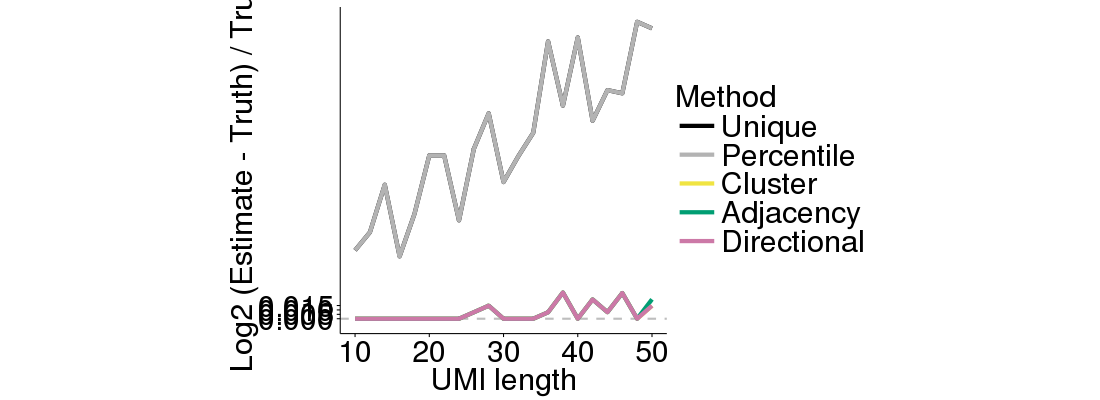

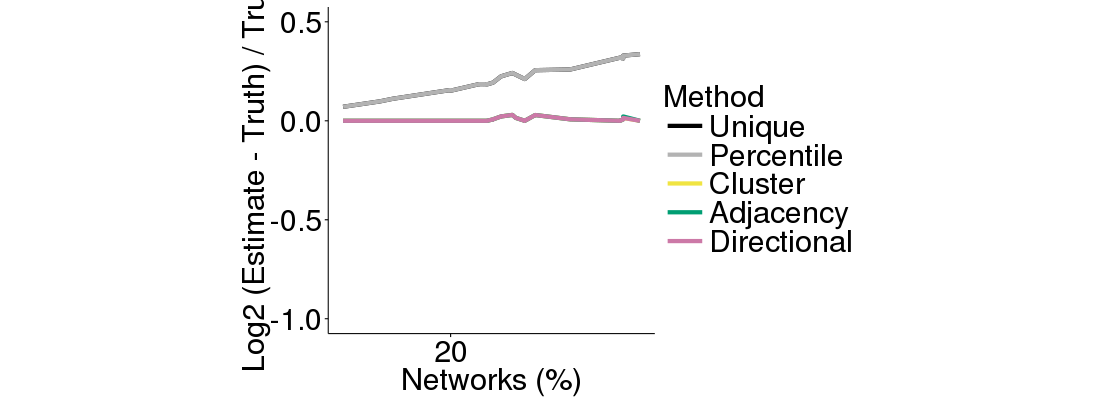

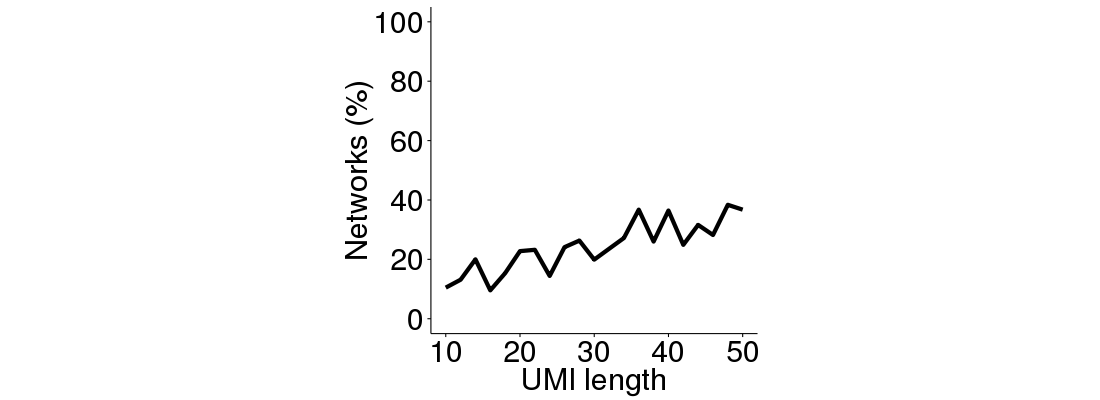

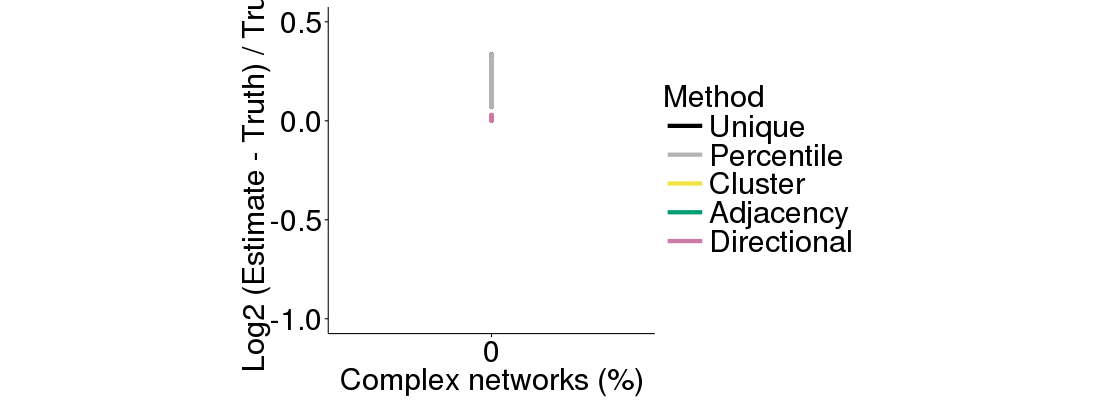

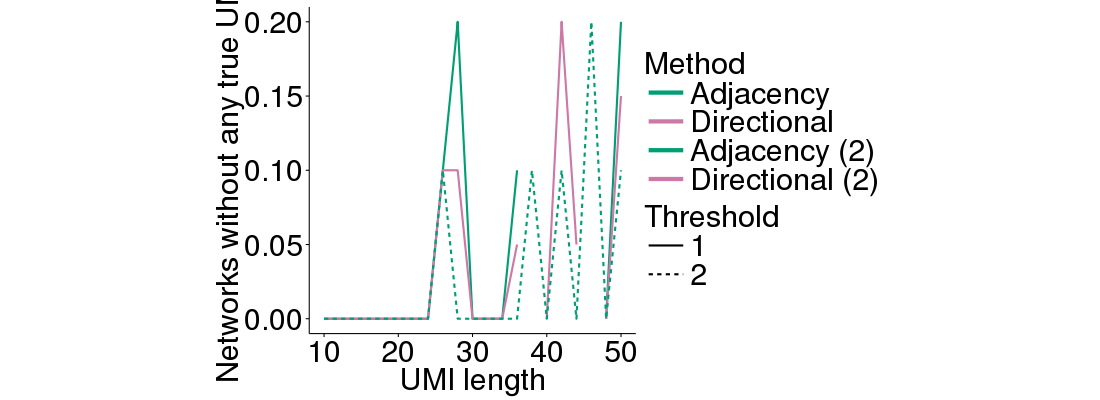

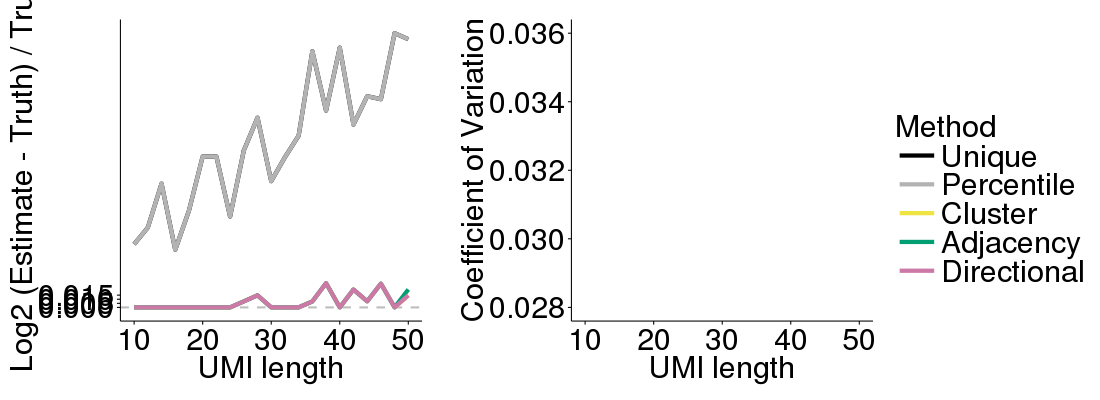

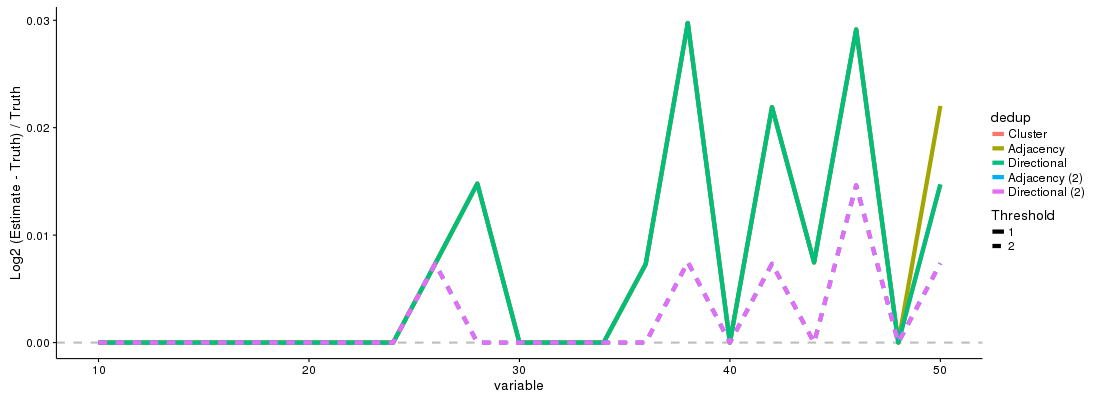

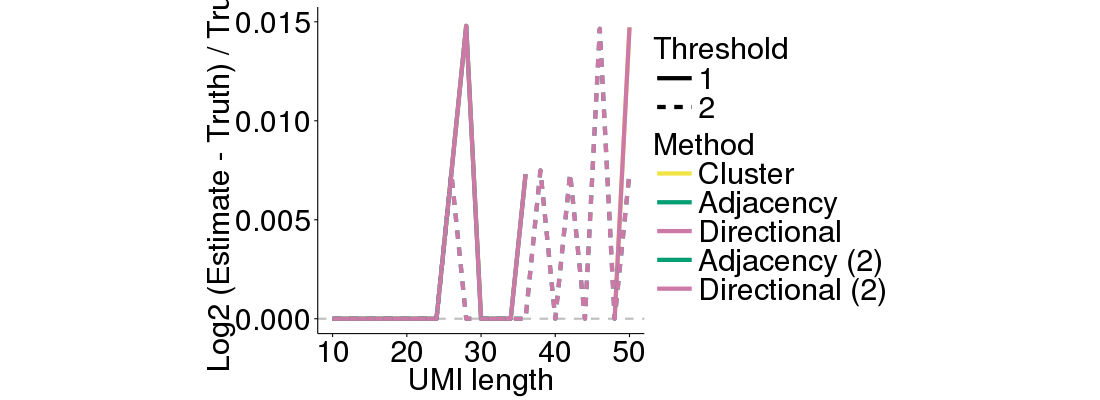

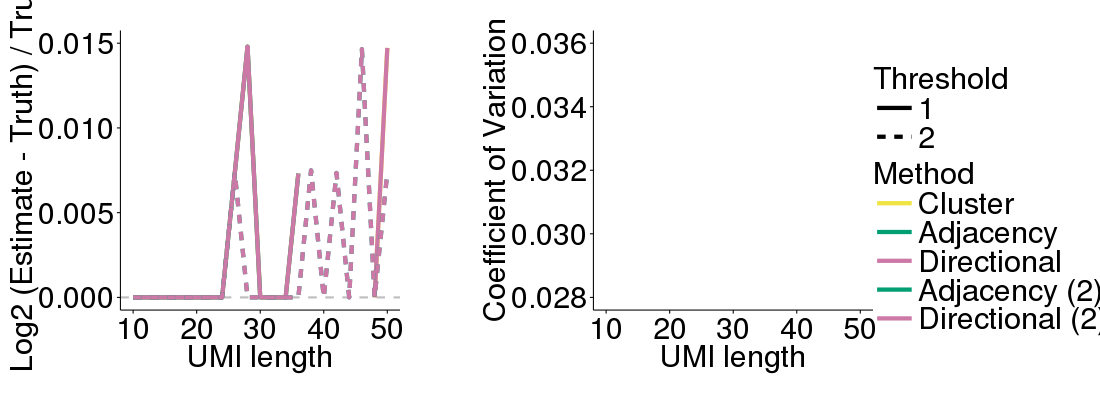

In [52]:
%%R -i df_UMI_length_extreme -w 1100 -h 400 -u px
breaks = seq(10, 50, 10)
network_breaks = seq(20, 100, 20)
plot_simulations(df_UMI_length_extreme, plotdir, difference=TRUE, umi_count=20,
                 variable="umi_length_xintercept", 
                 xlab="UMI length", 
                 xint=FALSE, breaks=breaks, network_breaks=network_breaks,
                 difference_y_breaks=seq(-1,0.5,0.5),
                 y_breaks=seq(0,0.015,0.005),
                 network_y_breaks=seq(0,100,20), complex_network_breaks=seq(0, 6.9, 1),
                 no_true_y_breaks=seq(0, 0.2, 0.05),
                 cv_y_breaks=seq(0.028, 0.036, 0.002),
                 plot_difference_networks=TRUE,
                 plot_difference_complex_networks=TRUE,
                 plot_truth_networks=TRUE,
                 plot_variable_name = "umi_length_extreme_xintercept",
                 plot_no_true_networks=TRUE)